importibuttondata.py:28: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  meta = meta.sort(axis=0) # sort the data in order of the sensor number
importibuttondata.py:63: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  anomalyDF = pd.DataFrame(anomaly, tempDF.index, tempDF.columns).sort(axis=1)
/Users/annascott2/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/annascott2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/annascott2/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns 

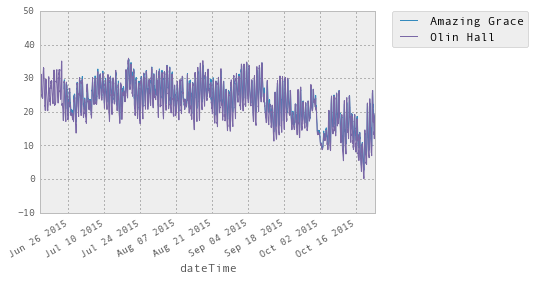

In [1]:
### Code
# import data
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import matplotlib
import matplotlib.pylab as pylab
from mpl_toolkits.basemap import Basemap
pylab.rcParams['figure.figsize'] = 16, 12
pd.options.display.mpl_style = 'default'
get_ipython().magic(u'matplotlib inline')
import ibuttonplots
import importibuttondata
%matplotlib inline

files = glob.glob('./data/*[tT].csv')
meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF0, anomalyDF0, meta0 = importibuttondata.importdata(files, meta0)

#files = glob.glob('./data/*[tT].csv')
files = glob.glob('./data/falldownload/*[tT].csv')
meta1 = pd.DataFrame(pd.read_csv('./data/falldownload/TempSensorFinal_results-4.csv', sep = ','))
#meta0 = pd.DataFrame(pd.read_csv('./data/bmoremetadata.csv', sep = ','))
tempDF1, anomalyDF1, meta1 = importibuttondata.importdata(files, meta1)

frames = [tempDF0, tempDF1]
tempDF = pd.concat(frames).resample('H')
anomalyDF = pd.concat([anomalyDF0, anomalyDF1])
meta = pd.concat([meta0, meta1.loc()[np.setdiff1d(meta1.sensornumber, meta0.sensornumber)]])

# Import Science Center observation data
date_spec = {'Date': [2, 3]}
urbandf = pd.read_csv('./data/observations/urban/2138216847366dat.csv', 
                      sep = ',', 
                      parse_dates = {'Date':[2, 3]},
                      #parse_dates = ['YYYYMMDD', 'HHM'],
                      keep_date_col=True).set_index('Date')
#urbandf.Temp[urbandf.Temp == '****'] = 'NaN' # replace stars with nans
urbandf.Temp = (urbandf.Temp.astype('float')) #-32)*5/9. #change the data to float
urbandf.Temp[urbandf.Temp > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
urbandf = urbandf[~((urbandf.index.month == 2) & (urbandf.index.day == 29))] # get rid of leap years
#df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
#df.DEWP = df.DEWP.astype('float') #change the data to float
urbandf = urbandf.resample('H')
urbandf.rename(columns = {'Temp' : 'TEMP'}, inplace = True)
urbandf.index = urbandf.index - pd.DateOffset(hours  = 4)

# Import hourly BWI data
date_spec = {'Date': [2]}
df = pd.read_csv('./data/observations/rural/4330976847362dat.csv', sep = ',', parse_dates = date_spec, keep_date_col=True).set_index('Date')
df.TEMP[df.TEMP == '****'] = 'NaN' # replace stars with nans
df.TEMP = (df.TEMP.astype('float')-32)*5/9. #change the data to float
df.TEMP[df.TEMP > 400] = 'NaN' #change unrealistic temp data to nan, data in F so 400 too high
df = df[~((df.index.month == 2) & (df.index.day == 29))] # get rid of leap years

df.DEWP[df.DEWP == '****'] = 'NaN' # replace stars with nans
df.DEWP = df.DEWP.astype('float') #change the data to float
ruraldf = df.resample('H')

import sqlite3
conn = sqlite3.connect('amazinggrace-weewx.sdb')
amazinggracedf = pd.read_sql_query('SELECT * from archive', conn)
amazinggracedf['dateTime']=pd.to_datetime(amazinggracedf['dateTime'], unit='s')
amazinggracedf.outTemp = (amazinggracedf.outTemp-32)*5./9.
amazinggracedf = amazinggracedf.set_index('dateTime')
amazinggracedf.index = amazinggracedf.index - pd.DateOffset(hours  = 5)

conn = sqlite3.connect('olinhall-weewx.sdb')
olinhalldf = pd.read_sql_query('SELECT * from archive', conn)
olinhalldf['dateTime']=pd.to_datetime(olinhalldf['dateTime'], unit='s')
olinhalldf.outTemp = (olinhalldf.outTemp-32)*5./9.
olinhalldf = olinhalldf.set_index('dateTime')
olinhalldf.index = olinhalldf.index - pd.DateOffset(hours  = 5)

amazinggracedf.outTemp.plot(label = 'Amazing Grace')
plt.hold(True)
olinhalldf.outTemp.plot(label = 'Olin Hall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

amazinggracedf = amazinggracedf[amazinggracedf.index.minute ==0]#amazinggracedf.resample('H')
olinhalldf = olinhalldf[olinhalldf.index.minute ==0]

ebaltsensorsi = np.where(meta['location:Longitude']>= -76.6125831)#-76.61)# -76.6072591 )

ebaltsensorsi = np.where(meta['location:Latitude']<= 39.32374)
parksi = np.where((meta['landcoverclass'] != 'impervious') & (meta['location:Longitude']>= -76.6125831)) # -76.61) )
plt.scatter(meta['location:Longitude'].iloc[ebaltsensorsi],
            meta['location:Latitude'].iloc[ebaltsensorsi], s = 100)
plt.scatter(meta['location:Longitude'].iloc[parksi],
            meta['location:Latitude'].iloc[parksi], color = 'g')

parksensors = meta.sensornumber.iloc[parksi]
ebaltsensors = meta.sensornumber.iloc[ebaltsensorsi]
nonparks = np.setdiff1d(ebaltsensors, parksensors)

selected = ebaltsensors

startdate = '2015-07-1' 
enddate = '2015-09-10'
matplotlib.rcParams.update({'font.size': 16})

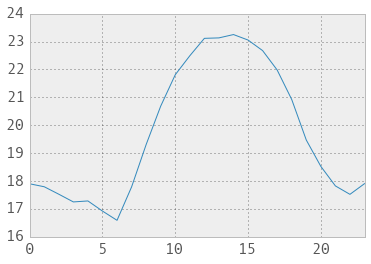

In [603]:
# import rooftest data 
files = glob.glob('./data/rooftest/*[tT].csv')
meta0 = pd.DataFrame(pd.read_csv('./data/rooftest/TempSensor1_results.csv', sep = ','))
rooftempDF, roofanomalyDF, roofmeta = importibuttondata.importdata(files, meta0)
rooftempDF = rooftempDF['2015-05-13':]

date_spec = {'Date': [2, 3]}
roofobsDF = pd.DataFrame(pd.read_csv('./data/rooftest/olinstationdatamay2015.csv', 
                        sep = ';', 
                        parse_dates = {'DateTime':[0,1]},
                          keep_date_col=True, 
                        )).set_index('DateTime')
roofobsDF.index = roofobsDF.index + pd.DateOffset(hours  = 14) # -10
if ~hasattr(roofobsDF, 'TEMP'):
    roofobsDF = roofobsDF.rename(columns={'inTemp':'TEMP'})
#roofobsDF
roofobsDF.TEMP.groupby(roofobsDF.index.hour).mean().plot()

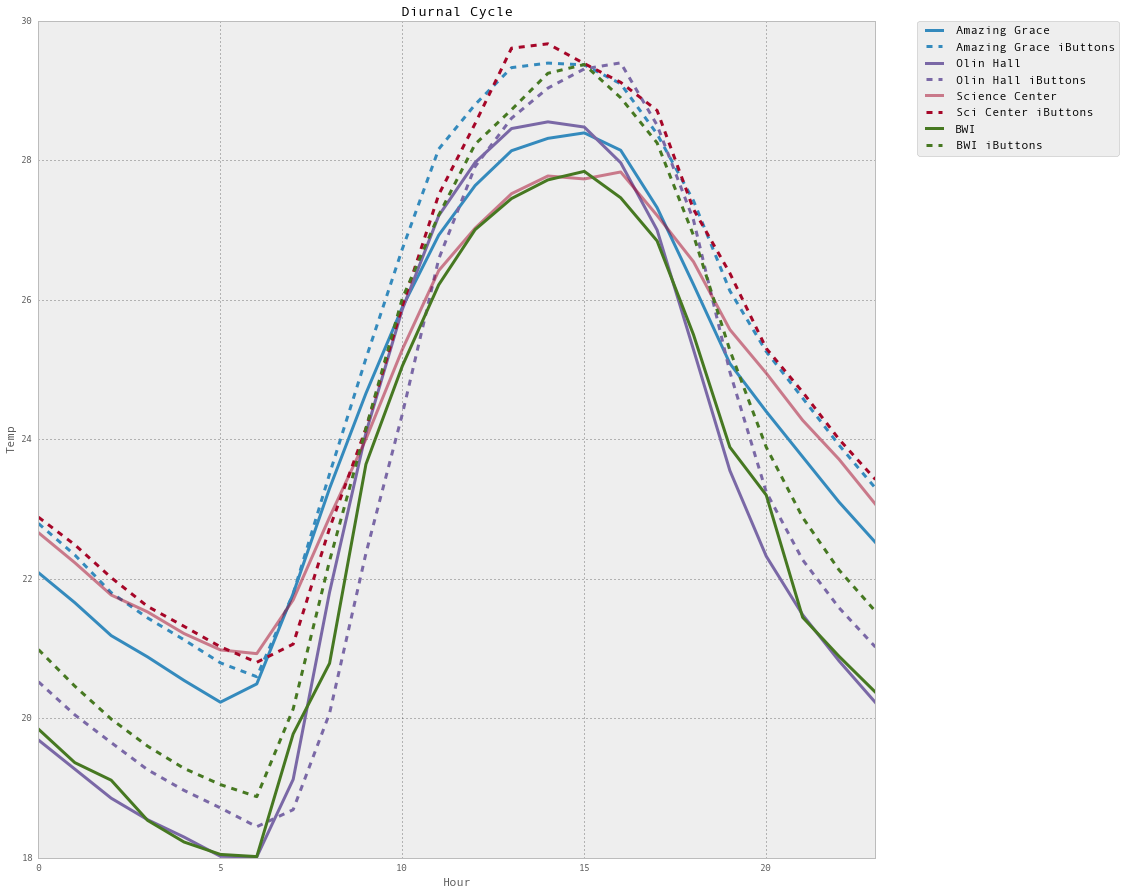

In [89]:
# all stations
fig = plt.figure(figsize=[15,15])
# Amazing Grace
start = '2015-08-07'
end = '2015-9-27'
amazinggracedf[start:end].outTemp.groupby(amazinggracedf[start:end].index.hour).mean().plot(
    label = 'Amazing Grace', 
    linewidth = 3, 
    color = pd.tools.plotting._get_standard_colors(4)[0]
    )
buttons = [2, 69] # Amazing Grace
tempDF[start:end][buttons].mean(axis=1).groupby(tempDF[start:end].index.hour).mean().plot(
    #yerr = ruraldf['2015-06-25':'2015-08-09'].TEMP.groupby(ruraldf['2015-06-25':'2015-08-09'].index.hour).std(),
    label = 'Amazing Grace iButtons',
    style = '--',`
    color = pd.tools.plotting._get_standard_colors(4)[0],
    linewidth = 3)

# Olin Hall
olinhalldf[start:end].outTemp.groupby(olinhalldf[start:end].index.hour).mean().plot(
    label = 'Olin Hall', 
    color = pd.tools.plotting._get_standard_colors(4)[1], 
    linewidth = 3
    )
buttons = [90, 49, 107, 86, 42, 53, 35, 96, 20] # Olin Hall
tempDF[start:end][buttons].mean(axis=1).groupby(tempDF[start:end].index.hour).mean().plot(
    #yerr = ruraldf['2015-06-25':'2015-08-09'].TEMP.groupby(ruraldf['2015-06-25':'2015-08-09'].index.hour).std(),
    label = 'Olin Hall iButtons',
    style = '--',
    color = pd.tools.plotting._get_standard_colors(4)[1], 
    linewidth = 3)

# Science Center
urbandf[start:end].TEMP.groupby(urbandf[start:end].index.hour).mean().plot(
    label = 'Science Center', 
    #yerr = urbandf['2015-06-25':'2015-08-09'].TEMP.groupby(urbandf['2015-06-25':'2015-08-09'].index.hour).std(),
    linewidth = 3,
    color = pd.tools.plotting._get_standard_colors(4)[2],  
    alpha = .5)
buttons = [108] #Science Center
tempDF[start:end][buttons].mean(axis=1).groupby(tempDF[start:end].index.hour).mean().plot(
    #yerr = ruraldf['2015-06-25':'2015-08-09'].TEMP.groupby(ruraldf['2015-06-25':'2015-08-09'].index.hour).std(),
    label = 'Sci Center iButtons',
    style = '--',
    linewidth = 3,
    color = pd.tools.plotting._get_standard_colors(4)[2])

# BWI
ruraldf[start:end].TEMP.groupby(ruraldf[start:end].index.hour).mean().plot(
    #yerr = ruraldf['2015-06-25':'2015-08-09'].TEMP.groupby(ruraldf['2015-06-25':'2015-08-09'].index.hour).std(),
    label = 'BWI',
    #alpha = .5, 
    linewidth = 3,
    color = pd.tools.plotting._get_standard_colors(4)[3])
buttons = [131, 133, 134, 135] #bwi
tempDF[start:end][buttons].mean(axis=1).groupby(tempDF[start:end].index.hour).mean().plot(
    #yerr = ruraldf['2015-06-25':'2015-08-09'].TEMP.groupby(ruraldf['2015-06-25':'2015-08-09'].index.hour).std(),
    label = 'BWI iButtons',
    style = '--',
    linewidth = 3,
    color = pd.tools.plotting._get_standard_colors(4)[3])

lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.xlabel('Hour')
plt.ylabel('Temp')
plt.title('Diurnal Cycle')

In [242]:
if ~hasattr(olinhalldf, 'TEMP'):
    olinhalldf = olinhalldf.rename(columns={'outTemp':'TEMP'})
    
if ~hasattr(amazinggracedf, 'TEMP'): 
    amazinggracedf = amazinggracedf.rename(columns={'outTemp':'TEMP'})   

In [605]:
def errorplot(buttons, obsDF, name = '$W_x$ Station', buttonDF = tempDF) : 
# function that takes button numbers and weather station dataframe and compares the buttons to the weather station
    nameList = map(str, buttons) + [name]
    fig0 = plt.figure(figsize = [32,16])
    # plot time series of temperature
    plt.subplot(3,1,1)
    plt.plot(buttonDF[startdate:enddate].resample('D').index, buttonDF[startdate:enddate][buttons].resample('D', how = 'min'))
    plt.plot(obsDF[startdate:enddate].resample('D').index, obsDF[startdate:enddate].TEMP.resample('D', how = 'min'), '--')
    plt.legend(nameList)
    plt.title('Minimum Daily Temperature near %s'%name)
    
    # plot time series of T_min error
    plt.subplot(3,1,2)
    plt.plot(buttonDF[startdate:enddate].resample('D', how = 'min').index, 
             (buttonDF[startdate:enddate][buttons].resample('D', how = 'min')-np.tile(ruraldf[startdate:enddate].TEMP.resample('D', how = 'min'), [buttonDF[startdate:enddate][buttons].resample('D', how = 'min').shape[1],1]).T),
             )
    plt.legend(nameList)
    plt.title('Error, $T_{min}$')
    
    # plot time series of T_max error 
    plt.subplot(3,1,3)
    plt.plot(buttonDF[startdate:enddate].resample('D', how = 'max').index, 
             (buttonDF[startdate:enddate][buttons].resample('D', how = 'max')-np.tile(ruraldf[startdate:enddate].TEMP.resample('D', how = 'max'), [buttonDF[startdate:enddate][buttons].resample('D', how = 'max').shape[1],1]).T),
             )
    plt.legend(nameList) #map(str, buttons)
    plt.title('Error, $T_{max}$')
        
    # plot boxplot of error for all data
    fig1 = plt.figure(figsize=[32,8])
    plt.subplot(1,4,1)
    axHandle = (buttonDF[startdate:enddate][buttons]-np.tile(obsDF[startdate:enddate].TEMP, [buttonDF[startdate:enddate][buttons].shape[1],1]).T).boxplot(return_type='axes')
    plt.title('Error, Hourly T')
    plt.ylim([-6,6])
    plt.ylabel('error, $^{\circ}$ C')
    plt.xlabel('iButton #')
    #plot boxplot of error  for T_min
    plt.subplot(1,4,2)
    axHandle = (buttonDF[startdate:enddate][buttons].resample('D', how = 'min')-np.tile(obsDF[startdate:enddate].TEMP.resample('D', how = 'min'), [buttonDF[startdate:enddate][buttons].resample('D', how = 'min').shape[1],1]).T).boxplot(return_type='axes')
    plt.title('Error, $T_{min}$')
    plt.ylim([-6,6])
    plt.ylabel('error, $^{\circ}$ C')
    plt.xlabel('iButton #')
    #plot boxplot for T_max
    plt.subplot(1,4,3)
    axHandle = (buttonDF[startdate:enddate][buttons].resample('D', how = 'max')-np.tile(obsDF[startdate:enddate].TEMP.resample('D', how = 'max'), [buttonDF[startdate:enddate][buttons].resample('D', how = 'max').shape[1],1]).T).boxplot(return_type='axes')
    plt.title('Error, $T_{max}$')
    plt.ylim([-6,6])
    plt.ylabel('error, $^{\circ}$ C')
    plt.xlabel('iButton #')
    
    # Diurnal cycle
    plt.subplot(1,4,4)
    #plt.errorbar(np.arange(0,24), 
    #             tempDF[startdate:enddate].groupby(tempDF[startdate:enddate].index.hour)[buttons].mean(),
    #             #yerr = tempDF[startdate:enddate].groupby(tempDF[startdate:enddate].index.hour)[buttons].mean().std(axis=1),
    #             label = buttons)
    #plt.errorbar(np.arange(0,24), 
    #             df[startdate:enddate].TEMP.groupby(df[startdate:enddate].index.hour).mean(),
    #             yerr = df[startdate:enddate].TEMP.groupby(df[startdate:enddate].index.hour).mean().std(),
    #             label = 'W')
    #plt.legend()
    #plt.xlim([0,23])
    plt.plot(buttonDF[startdate:enddate].groupby(buttonDF[startdate:enddate].index.hour)[buttons].mean())
    plt.plot(obsDF[startdate:enddate].TEMP.groupby(obsDF[startdate:enddate].index.hour).mean(), '--')
    plt.xlabel('hour')
    plt.ylabel('Temperature $^{\circ}$C')
    plt.legend(nameList, loc= 'upper left')
    plt.title('Diurnal Cycle')

    # Plot minimum temp versus minimum temp error (for available data)
    fig2 = plt.figure(figsize=[32,8])
    err = (buttonDF[startdate:enddate][buttons].resample('D', how = 'min')-np.tile(obsDF[startdate:enddate].TEMP.resample('D', how = 'min'), [buttonDF[startdate:enddate][buttons].resample('D', how = 'min').shape[1],1]).T).mean(axis=1)
    #err = err[1:] # lag error as a 6 am reading
    n=1
    for variable in ['TEMP', 'windSpeed', 'pressure', 'outHumidity', 'radiation', 'windDir']: 
        plt.subplot(2,4,n)
        
        x = olinhalldf[startdate:enddate][variable].resample('D', how= 'mean')
        if x.shape == err.shape : 
            plt.scatter(x[0:-1],err[1:])
            plt.xlabel('Mean %s'%variable)
            plt.ylabel('$Error, T_{min}$')

            #index = ~np.isnan(x[0:-1]) & ~np.isnan(err[1:])
            #p, res, _, _, _ = np.polyfit(x[index],err[index],1, full= True)
            index = ~np.isnan(x.values[0:-1]) & ~np.isnan(err.values[1:])
            p, res, _, _, _ = np.polyfit(x[0:-1][index],err[1:][index],1, full= True)

            m = p[0]
            b= p[1]
            plt.plot(x, m*x+b,color = 'k', # pd.tools.plotting._get_standard_colors(3)[0],
                     lw =2,
                     label = '$\Delta T_{u-r}=%.2f \cdot RH+%.2f$, $r^2 = %2.1f$'%(m,b,res),
                     )
            plt.legend()
        else: 
            try: 
                x = obsDF[startdate:enddate][variable].resample('D', how= 'mean')
                plt.scatter(x[0:-1],err[1:])
                plt.xlabel('Mean %s'%variable)
                plt.ylabel('$Error, T_{min}$')

                #index = ~np.isnan(x[0:-1]) & ~np.isnan(err[1:])
                #p, res, _, _, _ = np.polyfit(x[index],err[index],1, full= True)
                index = ~np.isnan(x.values[0:-1]) & ~np.isnan(err.values[1:])
                p, res, _, _, _ = np.polyfit(x[0:-1][index],err[1:][index],1, full= True)

                m = p[0]
                b= p[1]
                plt.plot(x, m*x+b,color = 'k', # pd.tools.plotting._get_standard_colors(3)[0],
                         lw =2,
                         label = '$\Delta T_{u-r}=%.2f \cdot RH+%.2f$, $r^2 = %2.1f$'%(m,b,res),
                         )
                plt.legend()
            #except DataError : 
            #    print 'Need numeric data for %s'%variable
            except KeyError : 
                print 'error: cannot map %s'%variable

        n = n+1
    
    return fig0, fig1, fig2

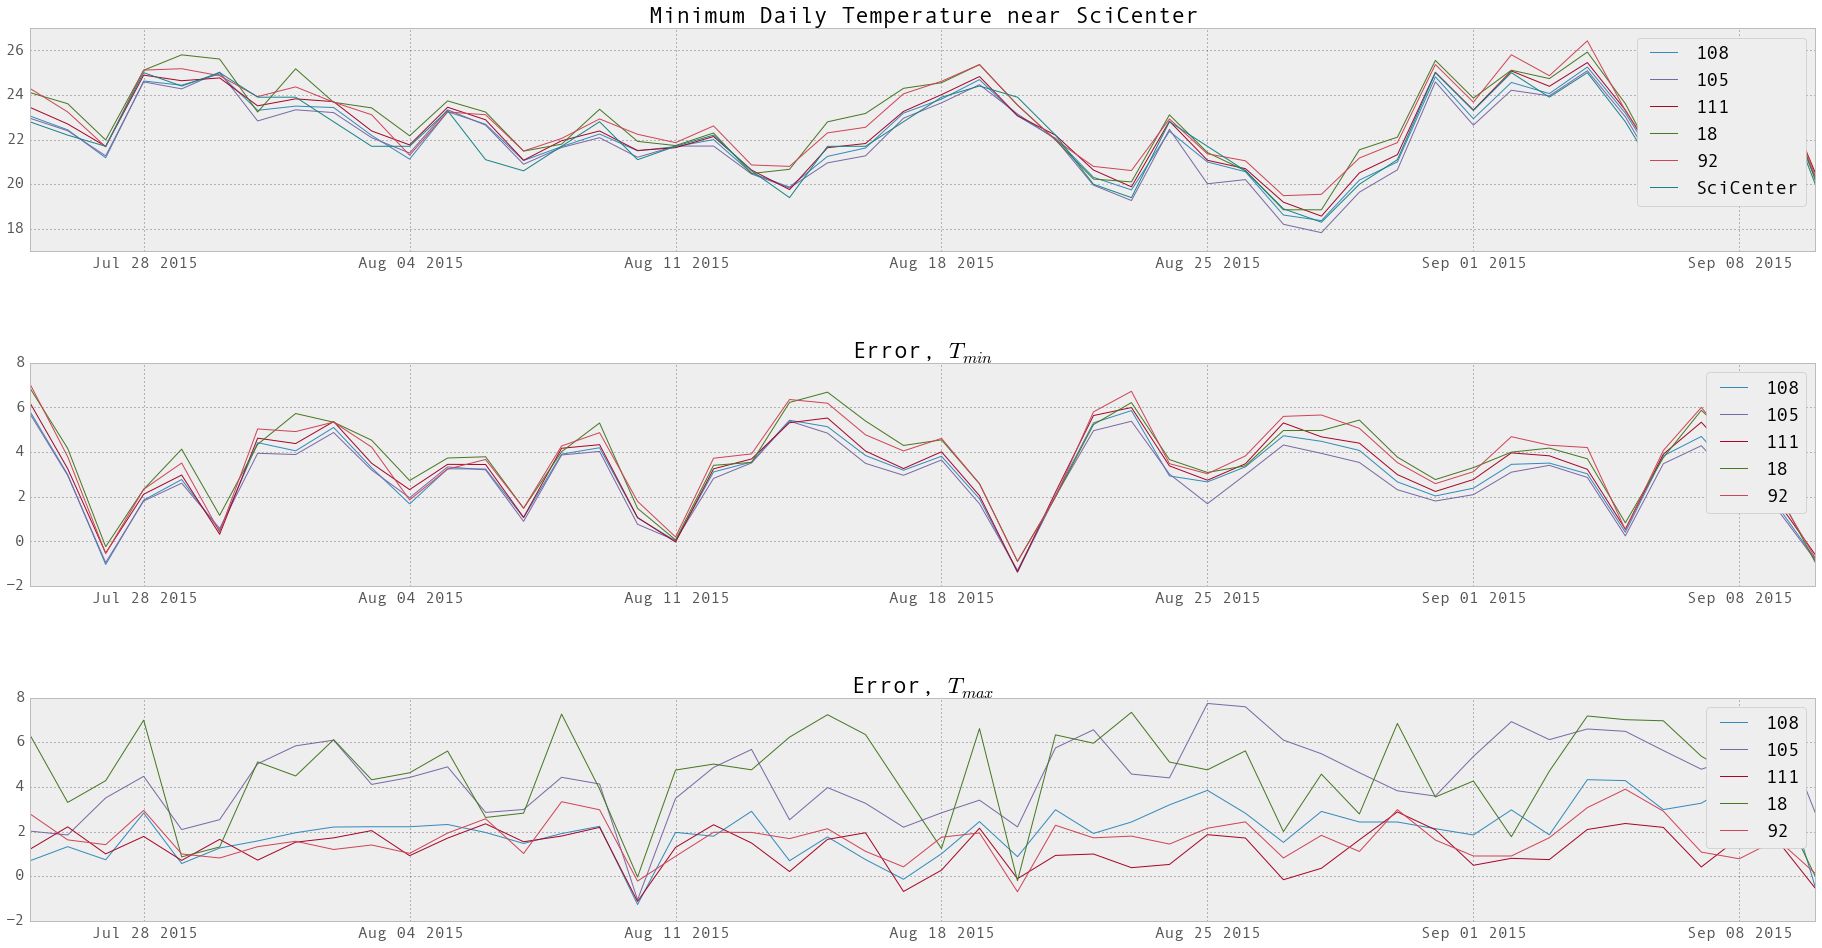

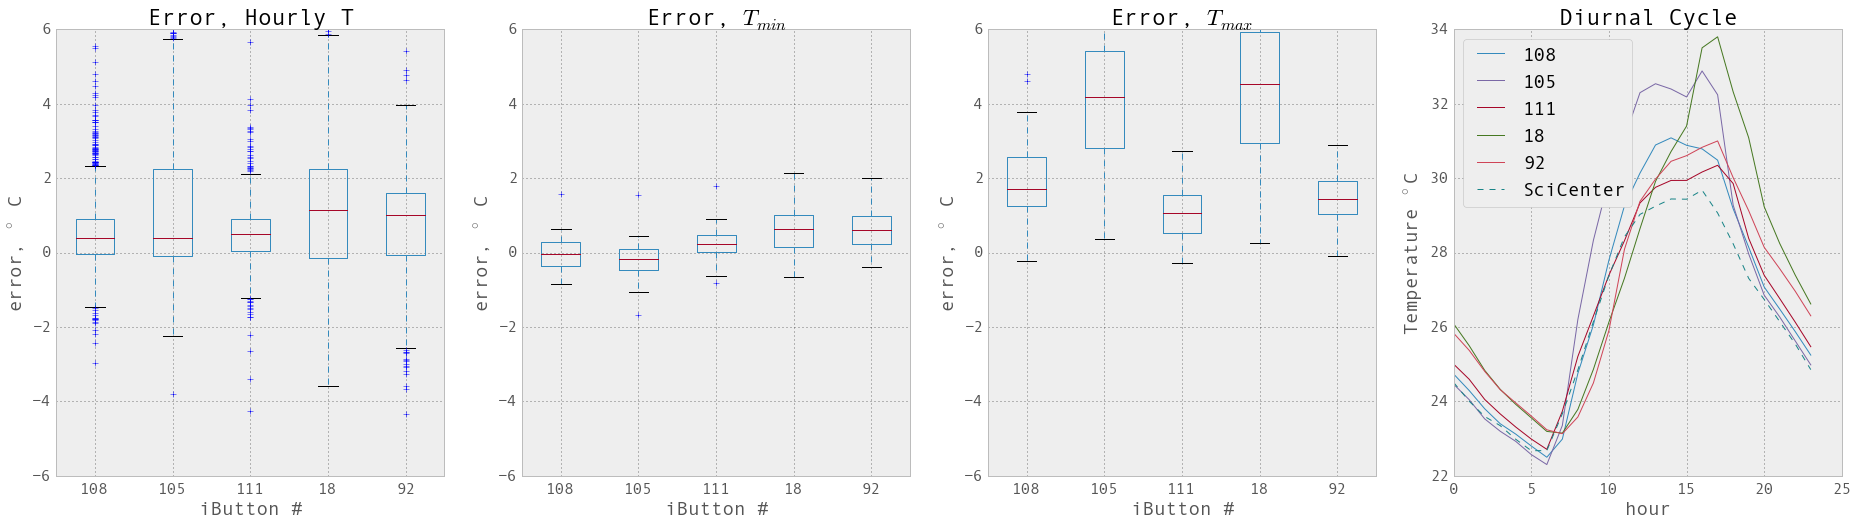

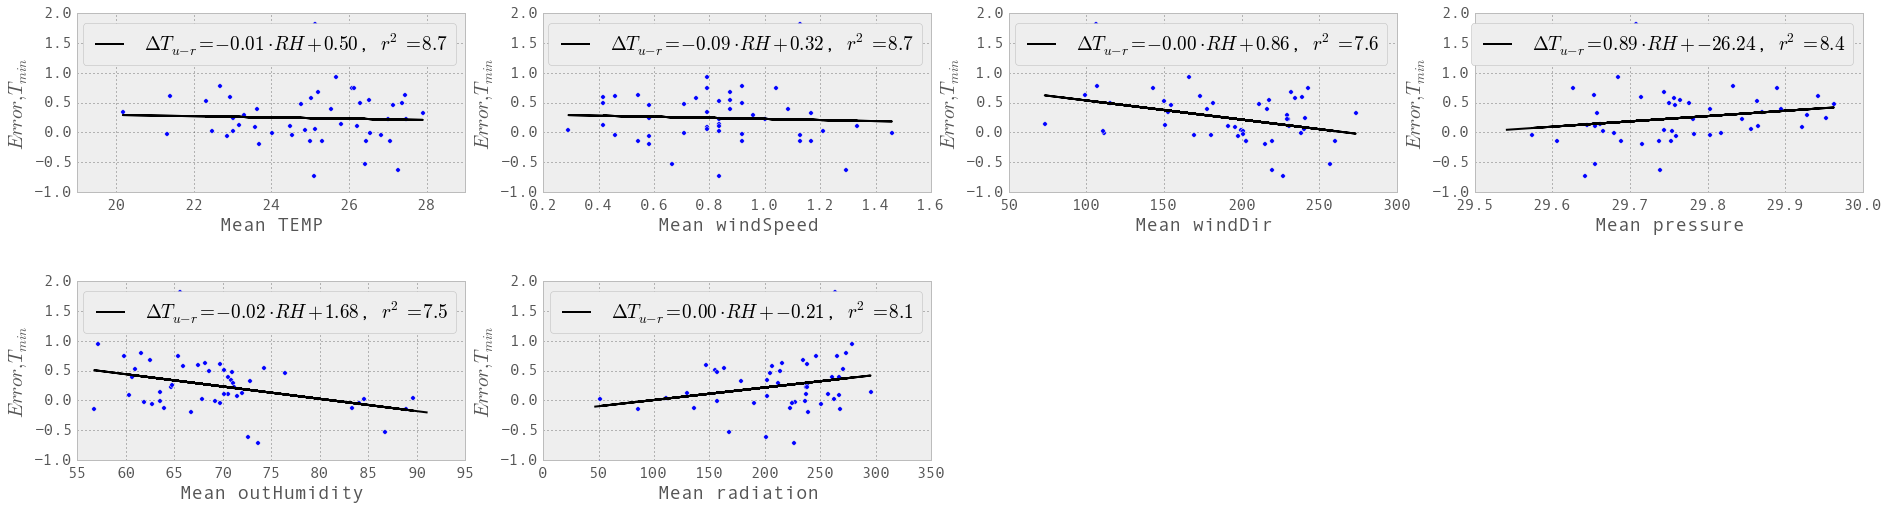

In [443]:
fig0, fig1, fig2 = errorplot([108, 105, 111, 18, 92], urbandf, "SciCenter")

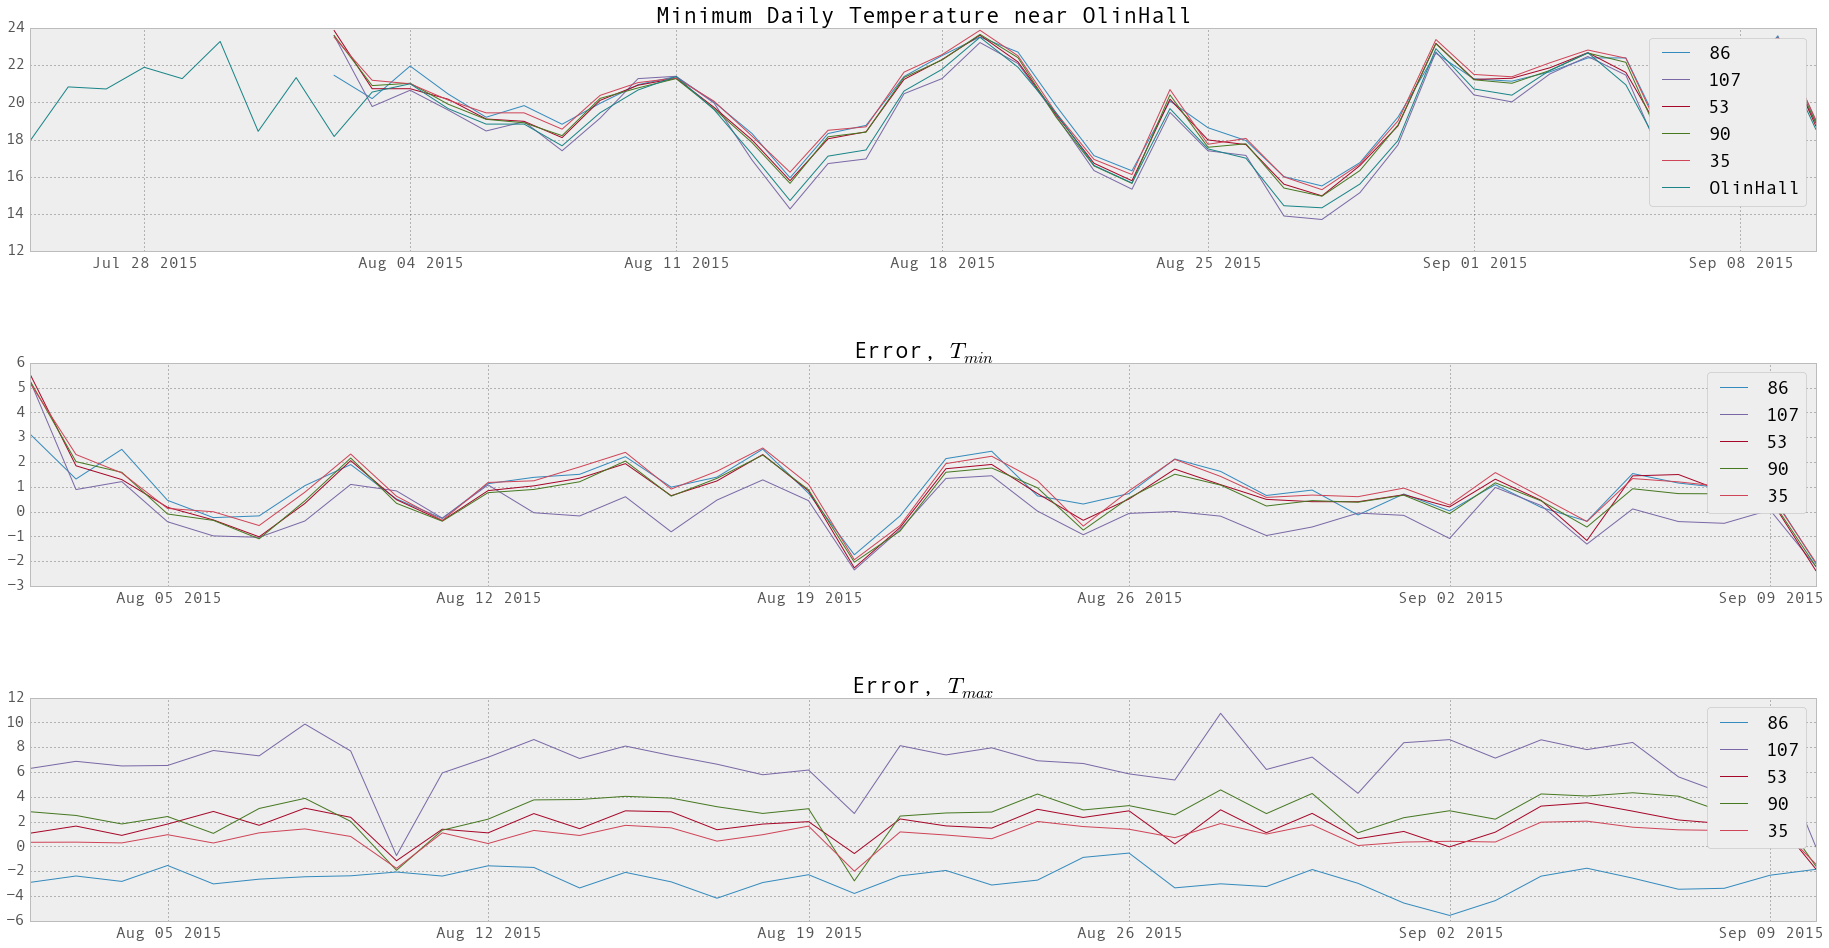

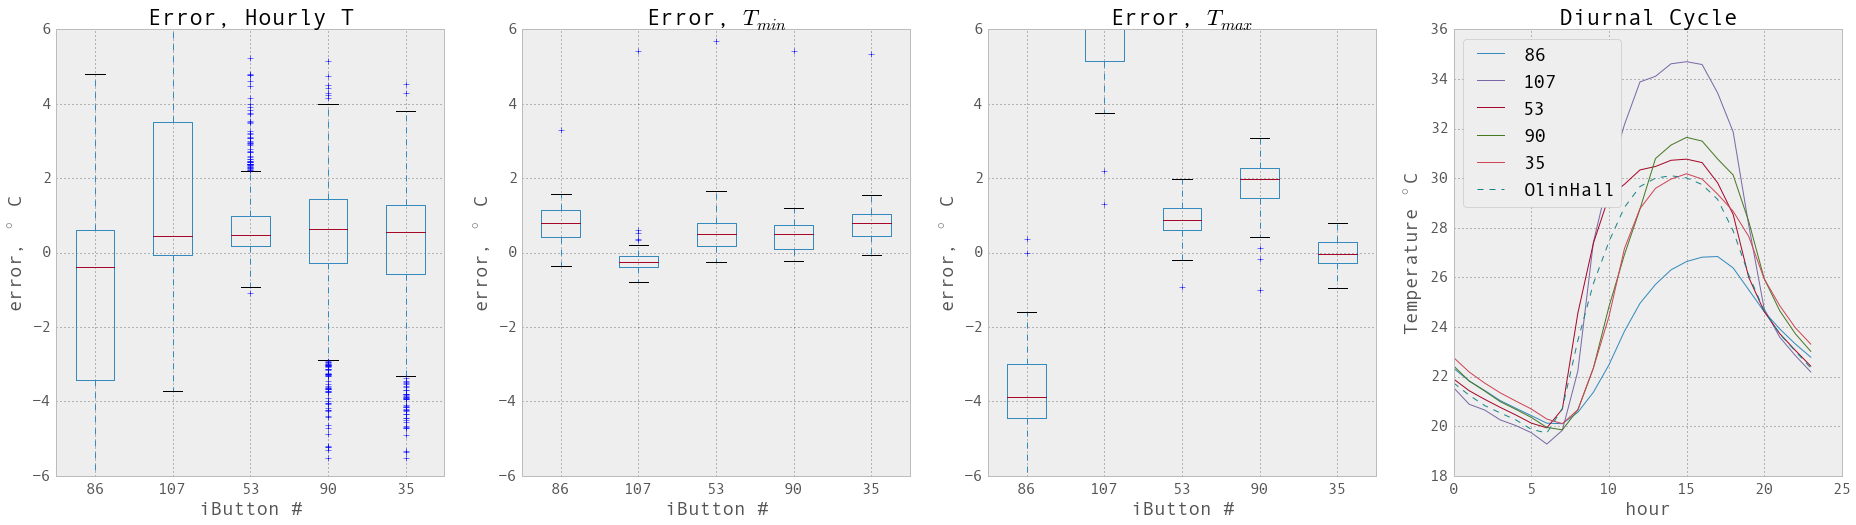

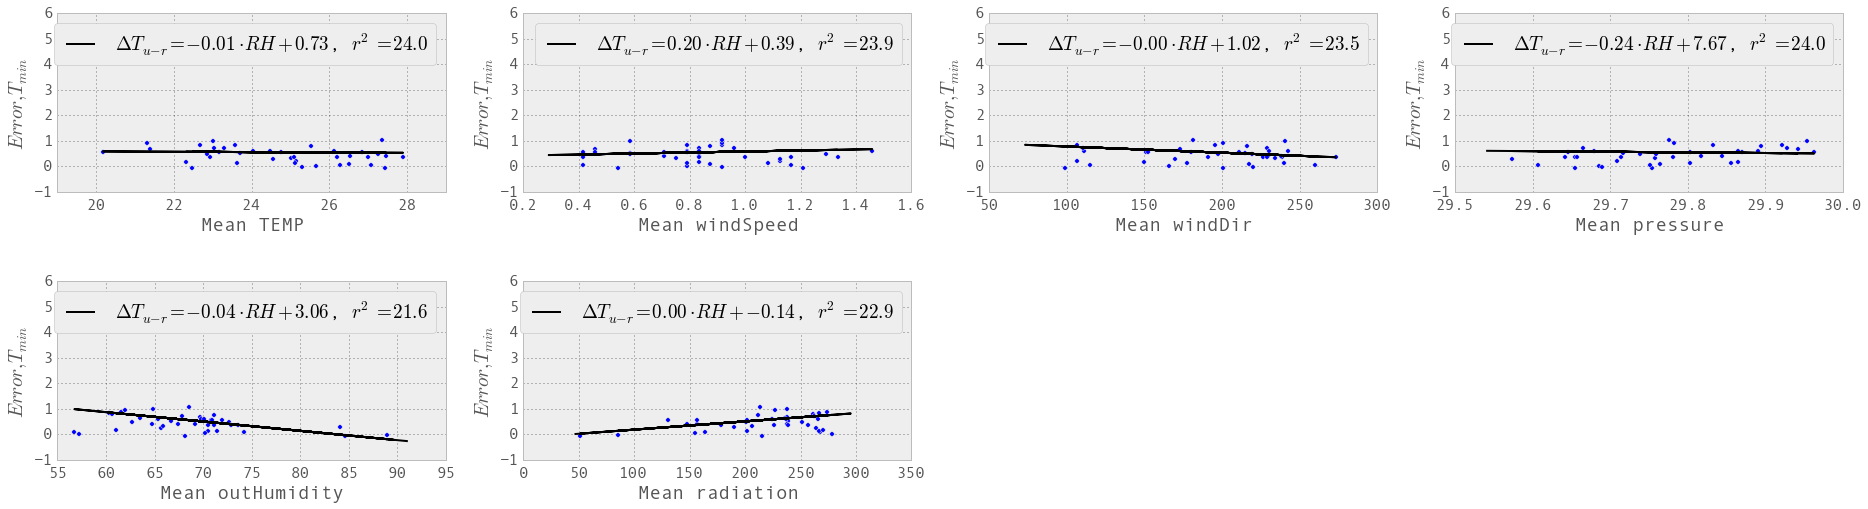

In [444]:
fig0, fig1, fig2 = errorplot([86, 107, 53, 90, 35], olinhalldf, "OlinHall")

In [625]:
tempDF[86]['2015-06-02']

Date
2015-06-02 00:00:00   NaN
2015-06-02 01:00:00   NaN
2015-06-02 02:00:00   NaN
2015-06-02 03:00:00   NaN
2015-06-02 04:00:00   NaN
2015-06-02 05:00:00   NaN
2015-06-02 06:00:00   NaN
2015-06-02 07:00:00   NaN
2015-06-02 08:00:00   NaN
2015-06-02 09:00:00   NaN
2015-06-02 10:00:00   NaN
2015-06-02 11:00:00   NaN
2015-06-02 12:00:00   NaN
2015-06-02 13:00:00   NaN
2015-06-02 14:00:00   NaN
2015-06-02 15:00:00   NaN
2015-06-02 16:00:00   NaN
2015-06-02 17:00:00   NaN
2015-06-02 18:00:00   NaN
2015-06-02 19:00:00   NaN
2015-06-02 20:00:00   NaN
2015-06-02 21:00:00   NaN
2015-06-02 22:00:00   NaN
2015-06-02 23:00:00   NaN
Freq: H, Name: 86, dtype: float64

DataError: No numeric types to aggregate

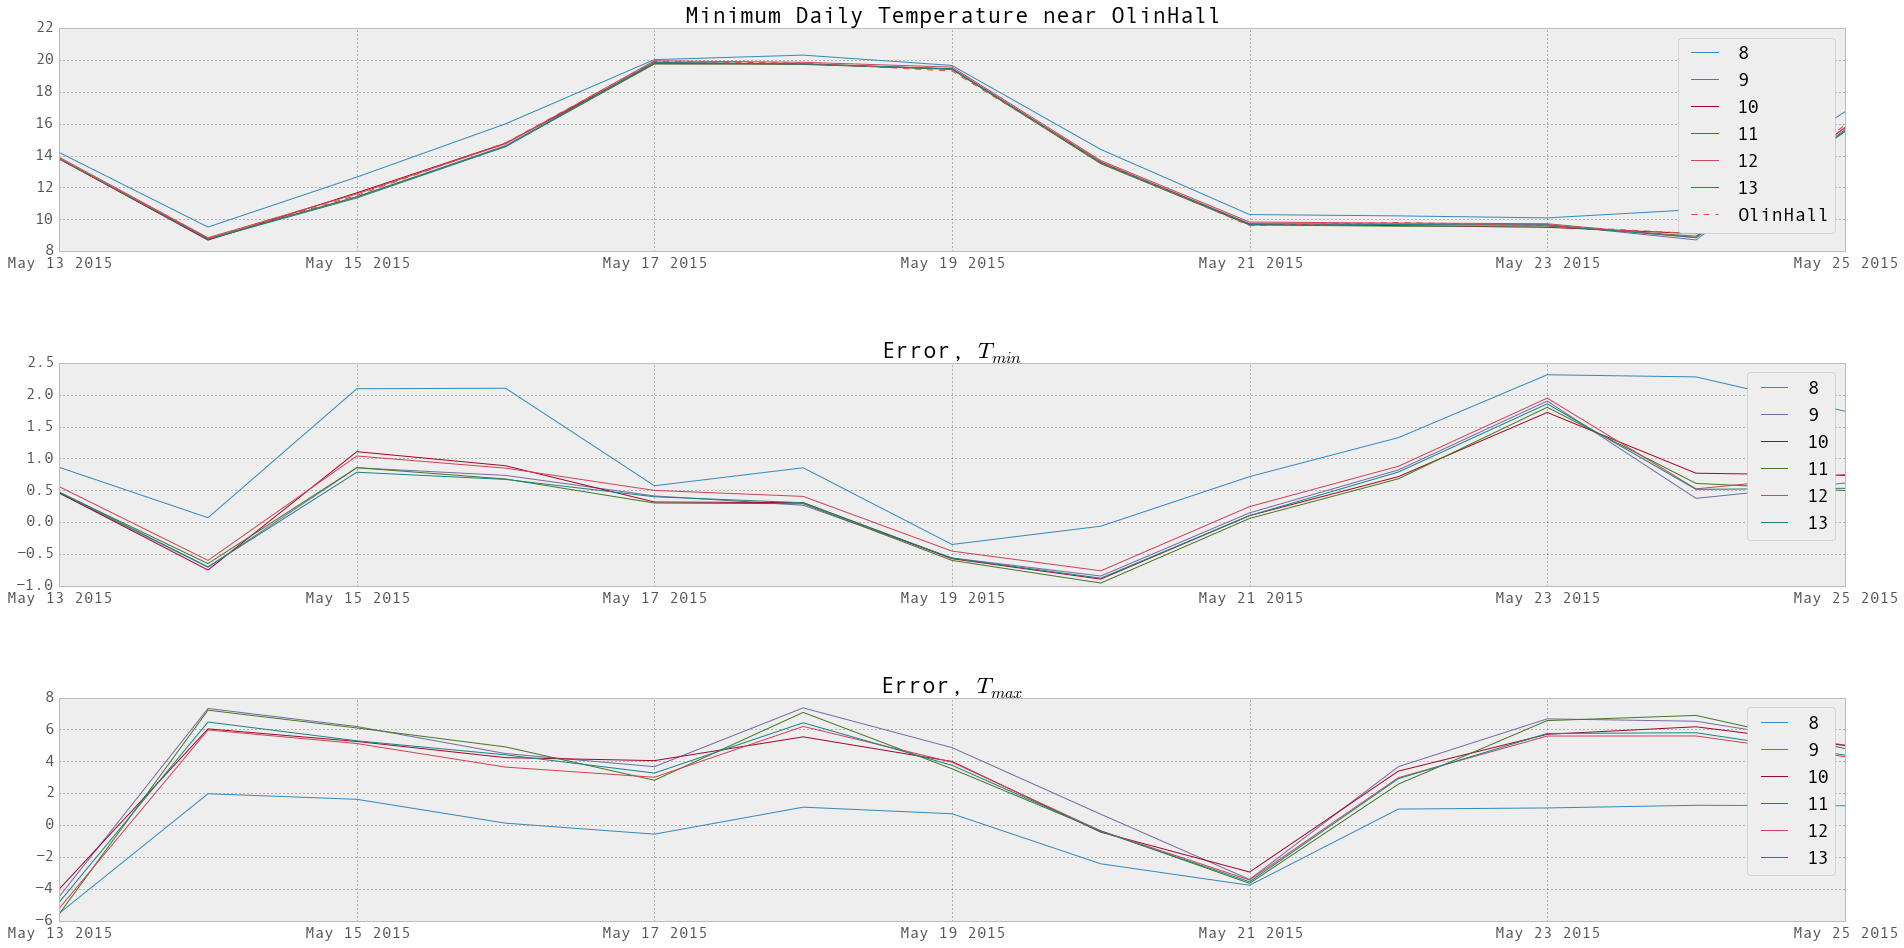

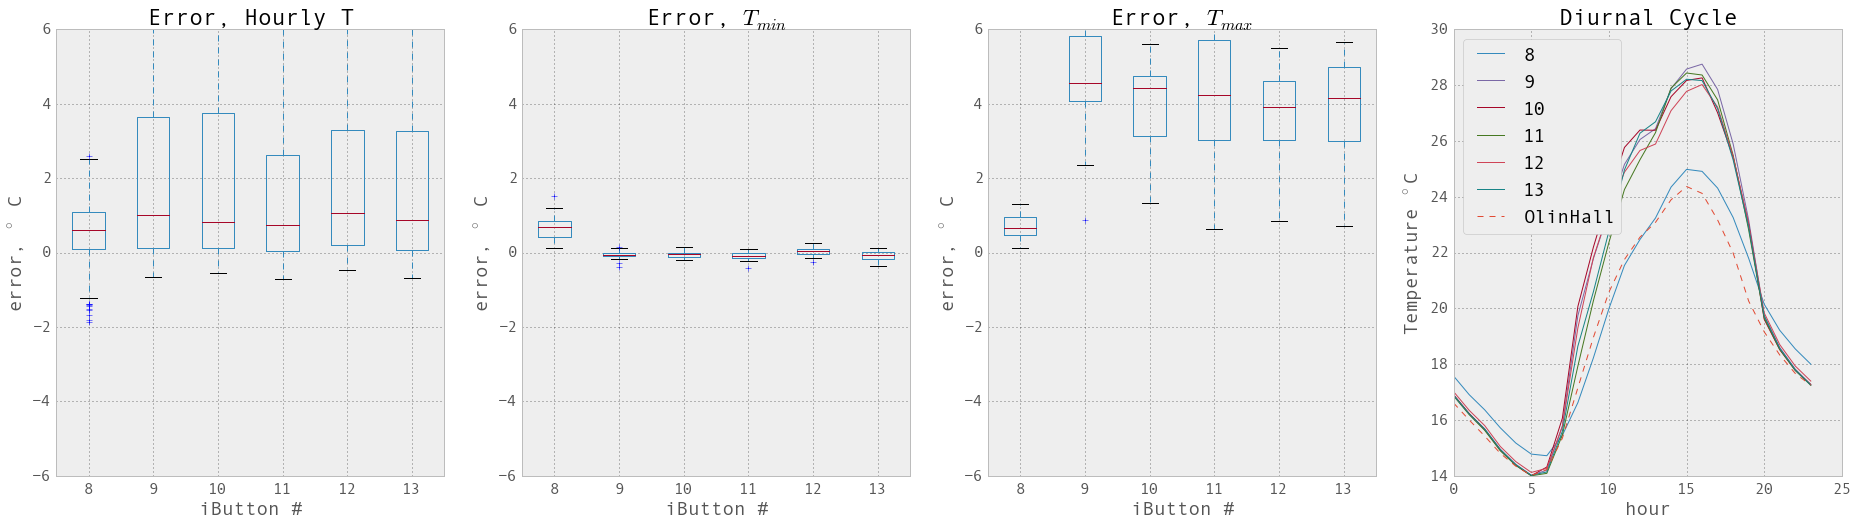

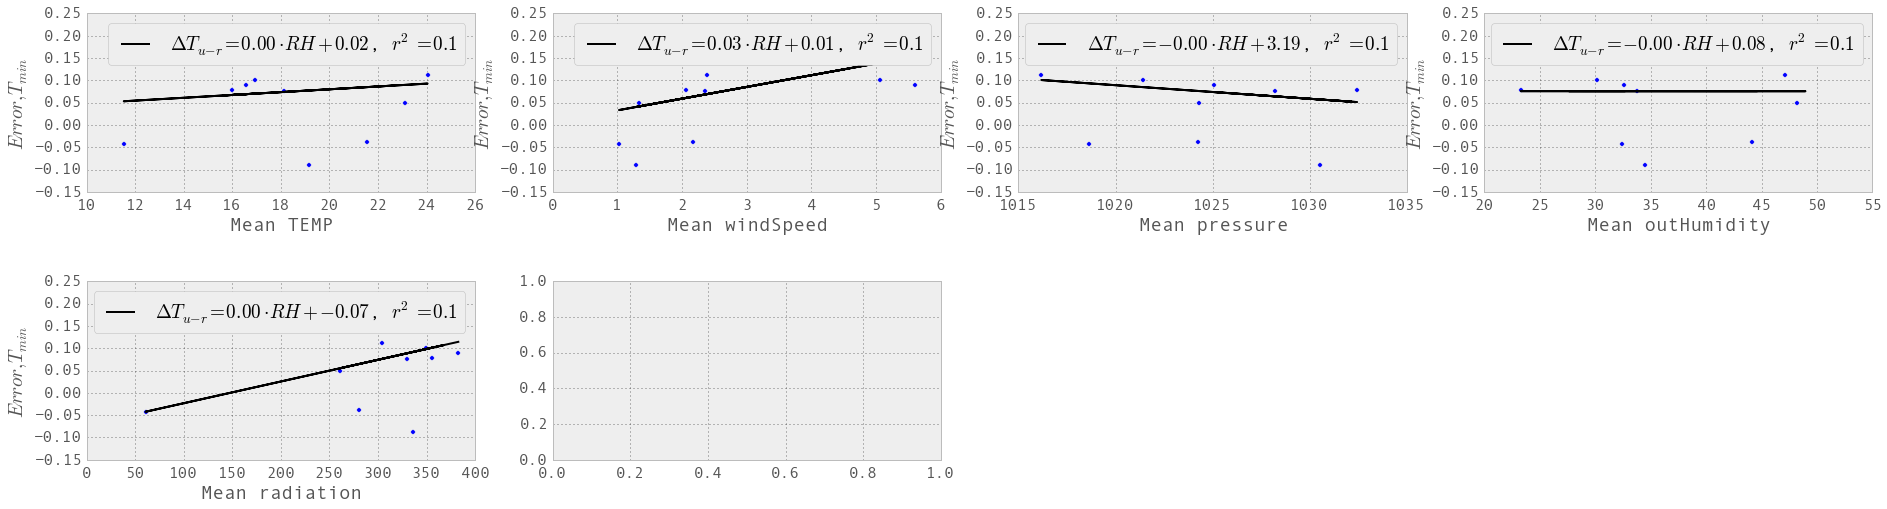

In [606]:
startdate = '2015-05-13'
enddate = '2015-05-25'
buttons = [8,9,10,11,12,13] #14, 15 appear to be inside data, don't have a diurnal cycle
fig0, fig1, fig2 = errorplot(buttons, roofobsDF.resample('H', how= 'first'), "OlinHall", rooftempDF)

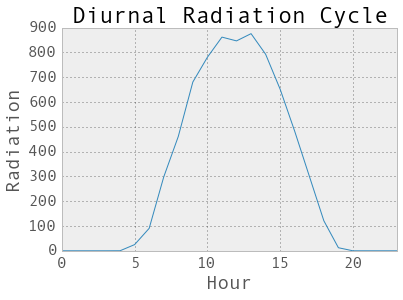

In [618]:
roofobsDF[startdate:enddate].radiation.groupby(roofobsDF[startdate:enddate].index.hour).mean().plot()
plt.title('Diurnal Radiation Cycle')
plt.xlabel('Hour')
plt.ylabel('Radiation')

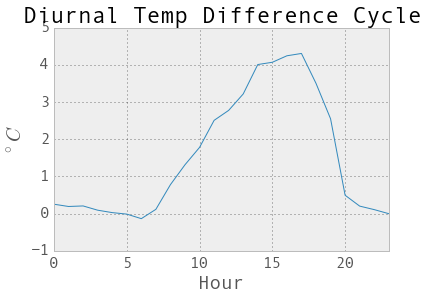

In [621]:
err = rooftempDF[11][startdate:enddate] - roofobsDF.TEMP.resample('H', how= 'first')[startdate:enddate]
err.groupby(err.index.hour).mean().plot()
plt.title('Diurnal Temp Difference Cycle')
plt.xlabel('Hour')
plt.ylabel('$^\circ C$')

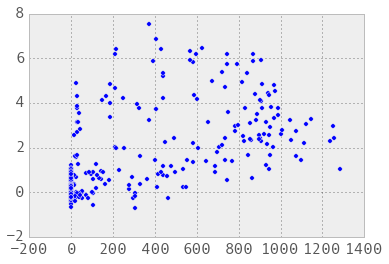

In [623]:
plt.scatter(roofobsDF.radiation.resample('H', how= 'first')[startdate:enddate], err)

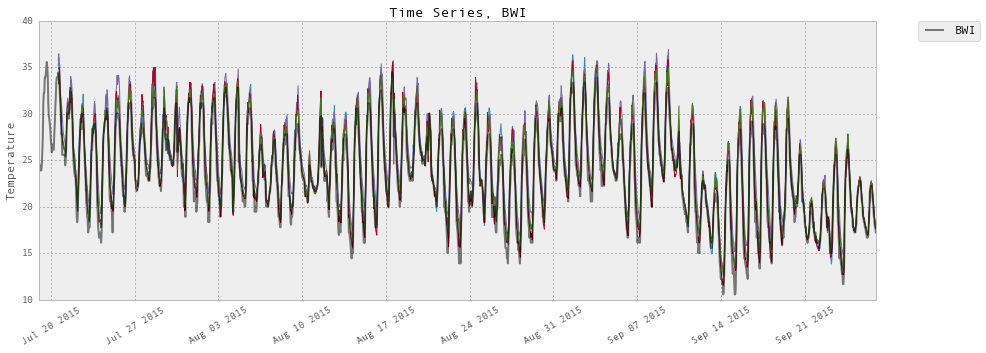

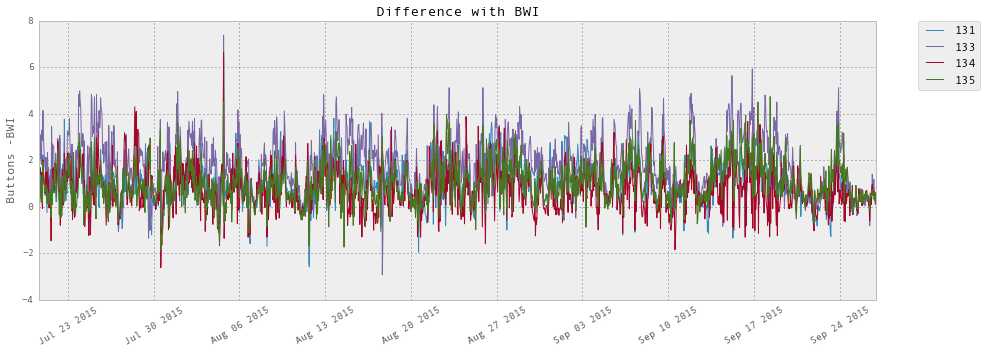

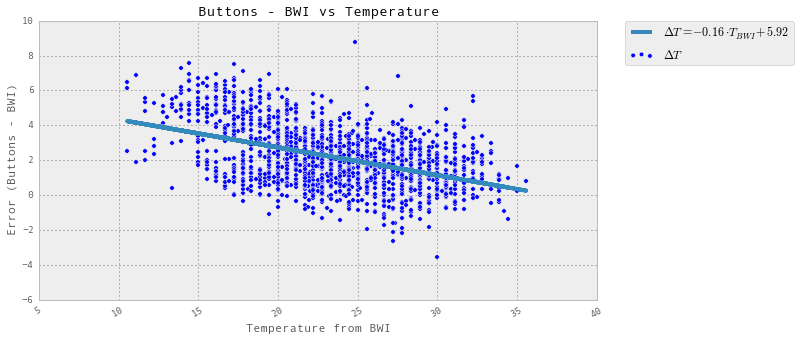

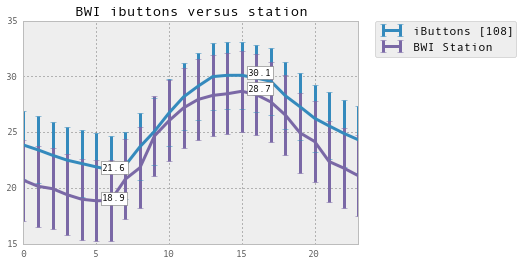

In [75]:
# plot timeseries of BWI and ibutton sensors
fig = plt.figure(figsize=[15,5])
#buttons = [131, 132, 133, 134, 135]
buttons = [131, 133, 134, 135] #BWI 133


plt.plot(tempDF['2015-07-19':'2015-09-26'].index, tempDF['2015-07-19':'2015-09-26'][buttons])
plt.plot(ruraldf['2015-07-19':'2015-09-26'].index, ruraldf['2015-07-19':'2015-09-26'].TEMP, 
         label = 'BWI', color = 'k', alpha = .5, linewidth = 2)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Time Series, BWI')
plt.ylabel('Temperature')
plt.xticks(rotation=30)
plt.show()
plt.savefig('plots/bwitimeseries.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# plot timeseries of ibutton sensors -BWI
fig = plt.figure(figsize=[15,5])
plt.plot(tempDF['2015-07-19':'2015-09-26'].index, tempDF['2015-07-19':'2015-09-26'][buttons]-ruraldf['2015-07-19':'2015-09-26'].TEMP)
#plt.plot(ruraldf['2015-07-19':'2015-09-26'].index, ruraldf['2015-07-19':'2015-09-26'].TEMP, label = 'BWI', linewidth = 3)
lgd = plt.legend(buttons, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Difference with BWI')
plt.xticks(rotation=30)
plt.ylabel('Buttons -BWI')
plt.show()
plt.savefig('plots/bwi-buttonstimeseries.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# Plot "error" vs temp 
buttons = [108]
fig = plt.figure(figsize=[10,5])
x = ruraldf['2015-07-19':'2015-09-26'].TEMP
y = tempDF['2015-07-19':'2015-09-26'][buttons]-ruraldf['2015-07-19':'2015-09-26'].TEMP
plt.scatter(x,y, 
            label = '$\Delta T$')

m,b = np.polyfit(x, y,1)
plt.plot(x, m*x+b, 
             color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{BWI}+%.2f$'%(m,b),
             )
plt.title('Buttons - BWI vs Temperature ')
plt.xlabel('Temperature from BWI')
plt.ylabel('Error (Buttons - BWI)')
plt.xticks(rotation=30)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.show()
plt.savefig('plots/errorvstempSC.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# plot the diurnal variation
#ibuttons
tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).plot(
    yerr = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).std(), 
    label = 'iButtons %s'%buttons, 
    linewidth = 3,
    )
maximum = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

minimum = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

#observations
ruraldf['2015-07-19':'2015-09-26'].TEMP.groupby(ruraldf['2015-07-19':'2015-09-26'].index.hour).mean().plot(
    yerr = ruraldf['2015-07-19':'2015-09-26'].TEMP.groupby(ruraldf['2015-07-19':'2015-09-26'].index.hour).mean().std(), 
    label = 'BWI Station', 
    linewidth = 3,)
maximum = ruraldf['2015-07-19':'2015-09-26'].TEMP.groupby(ruraldf['2015-07-19':'2015-09-26'].index.hour).mean().max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )
minimum = ruraldf['2015-07-19':'2015-09-26'].TEMP.groupby(ruraldf['2015-07-19':'2015-09-26'].index.hour).mean().min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )
plt.title('BWI ibuttons versus station')
lgd = plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.savefig('plots/bwibuttonsdiurnal.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

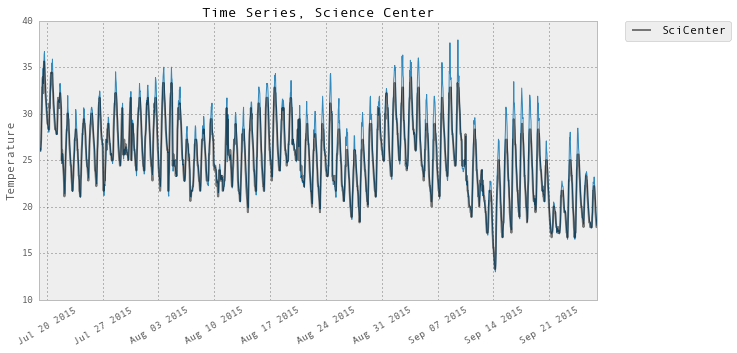

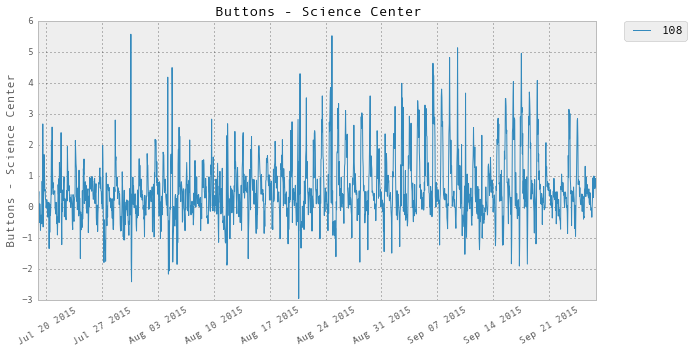

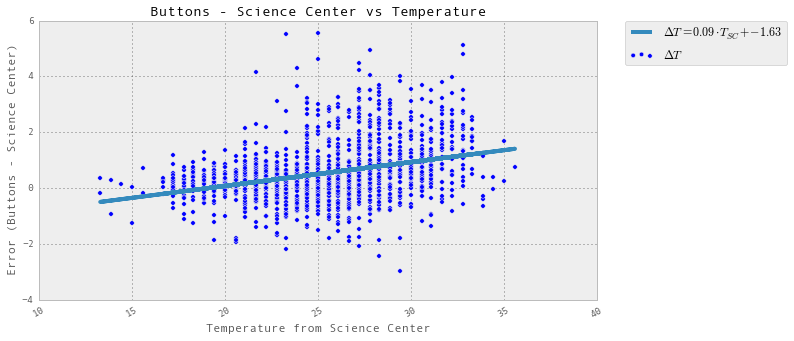

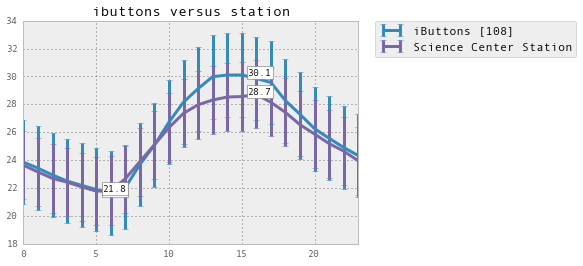

In [19]:
## plot timeseries of Science Center and ibutton sensors
fig = plt.figure(figsize=[10,5])
#buttons = [108, 111, 105, 81]
buttons = [108]
plt.plot(tempDF['2015-07-19':'2015-09-26'].index, tempDF['2015-07-19':'2015-09-26'][buttons])
plt.plot(urbandf['2015-07-19':'2015-09-26'].index, urbandf['2015-07-19':'2015-09-26'].TEMP, 
         label = 'SciCenter', color = 'k', alpha = .5, linewidth = 2)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Time Series, Science Center')
plt.ylabel('Temperature')
plt.xticks(rotation=30)
plt.show()
plt.savefig( 'plots/108sctimeseries.eps', format = 'eps', 
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# plot timeseries of ibutton sensors -BWI
fig = plt.figure(figsize=[10,5])
plt.plot(tempDF['2015-07-19':'2015-09-26'].index, tempDF['2015-07-19':'2015-09-26'][buttons]-urbandf['2015-07-19':'2015-09-26'].TEMP)
#plt.plot(ruraldf['2015-07-19':'2015-09-26'].index, ruraldf['2015-07-19':'2015-09-26'].TEMP, label = 'BWI', linewidth = 3)
lgd = plt.legend(buttons, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Buttons - Science Center')
plt.ylabel('Buttons - Science Center')
plt.xticks(rotation=30)
plt.show()
plt.savefig( 'plots/108-sctimeseries.eps', format = 'eps',
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# Plot "error" vs temp 
fig = plt.figure(figsize=[10,5])
x = urbandf['2015-07-19':'2015-09-26'].TEMP
y = tempDF['2015-07-19':'2015-09-26'][buttons]-urbandf['2015-07-19':'2015-09-26'].TEMP
plt.scatter(x,y, 
            label = '$\Delta T$')

m,b = np.polyfit(x, y,1)
plt.plot(x, m*x+b, 
             color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
plt.title('Buttons - Science Center vs Temperature ')
plt.xlabel('Temperature from Science Center')
plt.ylabel('Error (Buttons - Science Center)')
plt.xticks(rotation=30)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.show()
plt.savefig('plots/errorvstempSC.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

# Plot diurnal variation
#ibuttons
tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).plot(
    yerr = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).std(), 
    label = 'iButtons %s'%buttons, 
    linewidth = 3,
    )
maximum = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

minimum = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

#observations
urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().plot(
    yerr = urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().std(), 
    label = 'Science Center Station', 
    linewidth = 3,)
maximum = urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )
minimum = urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )
plt.title('ibuttons versus station')
lgd = plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.savefig('plots/bwibuttonsdiurnal.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

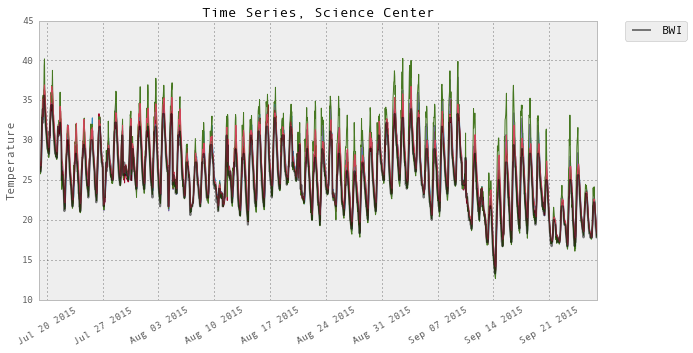

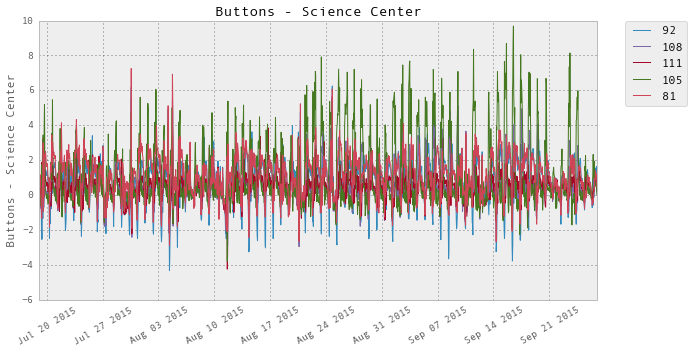

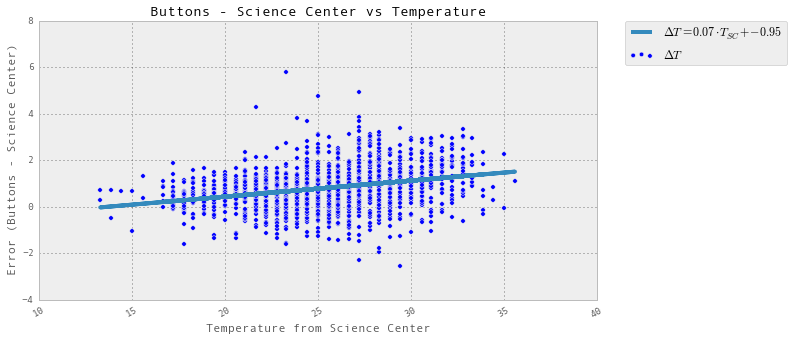

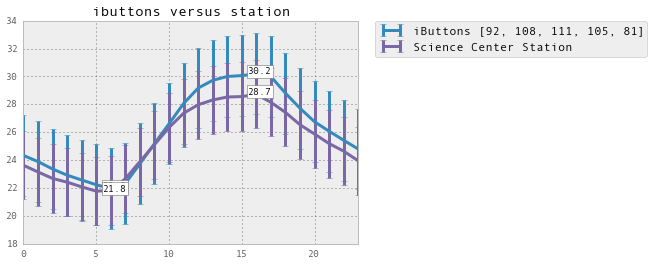

In [33]:
# plot time series of everything
fig = plt.figure(figsize=[10,5])
buttons = [92, 108, 111, 105, 81]
plt.plot(tempDF['2015-07-19':'2015-09-26'].index, tempDF['2015-07-19':'2015-09-26'][buttons])
plt.plot(urbandf['2015-07-19':'2015-09-26'].index, urbandf['2015-07-19':'2015-09-26'].TEMP, 
         label = 'BWI', color = 'k', alpha = .5, linewidth = 2)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Time Series, Science Center')
plt.ylabel('Temperature')
plt.xticks(rotation=30)
plt.show()
plt.savefig('plots/buttonssctimeseries.eps')

# plot timeseries of ibutton sensors -BWI
fig = plt.figure(figsize=[10,5])
plt.plot(tempDF['2015-07-19':'2015-09-26'].index, tempDF['2015-07-19':'2015-09-26'][buttons]-urbandf['2015-07-19':'2015-09-26'].TEMP)
#plt.plot(ruraldf['2015-07-19':'2015-09-26'].index, ruraldf['2015-07-19':'2015-09-26'].TEMP, label = 'BWI', linewidth = 3)
plt.legend(buttons, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Buttons - Science Center')
plt.ylabel('Buttons - Science Center')
plt.xticks(rotation=30)
plt.show()
plt.savefig('plots/buttons-sctimeseries.eps')

# Plot "error" vs temp 
fig = plt.figure(figsize=[10,5])
x = urbandf['2015-07-19':'2015-09-26'].TEMP
y = tempDF['2015-07-19':'2015-09-26'][buttons].mean(axis=1)-urbandf['2015-07-19':'2015-09-26'].TEMP
plt.scatter(x,y, 
            label = '$\Delta T$')

m,b = np.polyfit(x, y,1)
plt.plot(x, m*x+b, 
             color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
plt.title('Buttons - Science Center vs Temperature ')
plt.xlabel('Temperature from Science Center')
plt.ylabel('Error (Buttons - Science Center)')
plt.xticks(rotation=30)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.show()
plt.savefig('plots/errorvstempSC.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')


# plot the diurnal variation

# Plot diurnal variation
#ibuttons
tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).plot(
    yerr = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).std(), 
    label = 'iButtons %s'%buttons, 
    linewidth = 3,
    )
maximum = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

minimum = tempDF['2015-07-19':'2015-09-26'][buttons].groupby(tempDF['2015-07-19':'2015-09-26'].index.hour).mean().mean(axis=1).min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

#observations
urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().plot(
    yerr = urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().std(), 
    label = 'Science Center Station', 
    linewidth = 3,)
maximum = urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )
minimum = urbandf['2015-07-19':'2015-09-26'].TEMP.groupby(urbandf['2015-07-19':'2015-09-26'].index.hour).mean().min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )
plt.title('ibuttons versus station')
lgd = plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.savefig('plots/bwibuttonsdiurnal.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')

plt.savefig('plots/buttonsscicenterdiurnal.eps')

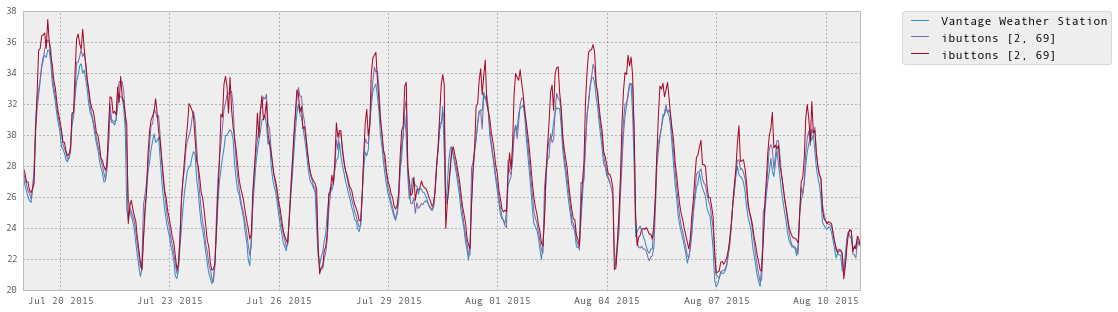

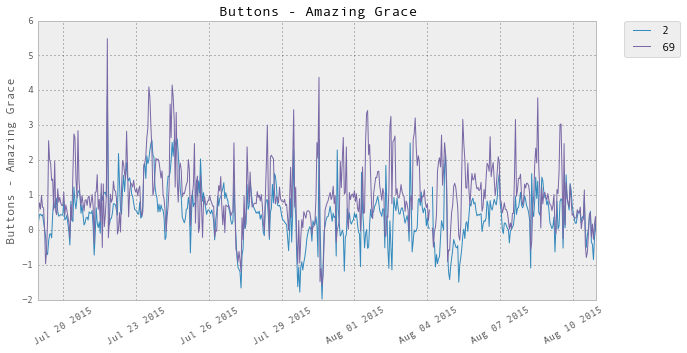

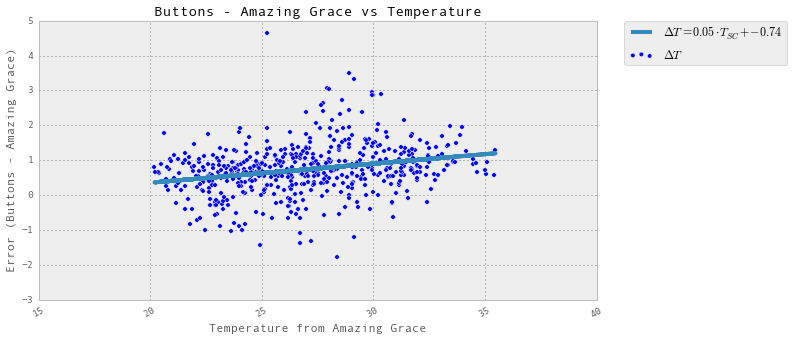

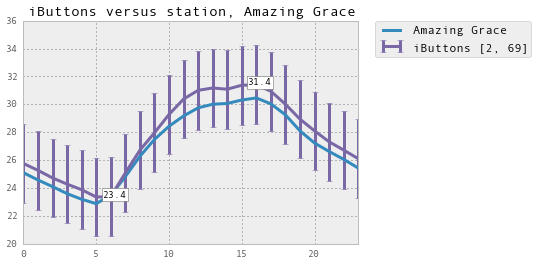

In [77]:
# Buttons vs. Amazing Grace 

# Time series of temperatures
fig = plt.figure(figsize=[15,5])
buttons = [2, 69] # Amazing Grace

plt.plot(amazinggracedf['2015-07-19':'2015-08-10'].index, amazinggracedf['2015-07-19':'2015-08-10'].outTemp, label ='Vantage Weather Station')
plt.plot(tempDF['2015-07-19':'2015-08-10'].index, tempDF['2015-07-19':'2015-08-10'][buttons], label = 'ibuttons %s'%buttons )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

# plot timeseries of ibutton sensors -amazing grace
fig = plt.figure(figsize=[10,5])
plt.plot(tempDF['2015-07-19':'2015-08-10'].index, tempDF['2015-07-19':'2015-08-10'][buttons]-amazinggracedf['2015-07-19':'2015-08-10'].outTemp)
plt.legend(buttons, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Buttons - Amazing Grace')
plt.ylabel('Buttons - Amazing Grace')
plt.xticks(rotation=30)
plt.show()

# Scatter "error" vs temp 
fig = plt.figure(figsize=[10,5])
x = amazinggracedf['2015-07-19':'2015-08-10'].outTemp
y = tempDF['2015-07-19':'2015-08-10'][buttons].mean(axis=1)-amazinggracedf['2015-07-19':'2015-08-10'].outTemp
plt.scatter(x,y, 
            label = '$\Delta T$')

index = np.isfinite(x) & np.isfinite(y)
m,b = np.polyfit(x[index], y[index],1)
plt.plot(x, m*x+b, 
             color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
plt.title('Buttons - Amazing Grace vs Temperature ')
plt.xlabel('Temperature from Amazing Grace')
plt.ylabel('Error (Buttons - Amazing Grace)')
plt.xticks(rotation=30)
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.show()
plt.savefig('plots/errorvstempAG.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')


# diurnal cycle 
x.groupby(x.index.hour).mean().plot(
    label = 'Amazing Grace', 
    linewidth = 3
    )

#ibuttons
tempDF['2015-07-19':'2015-08-10'][buttons].groupby(tempDF['2015-07-19':'2015-08-10'].index.hour).mean().mean(axis=1).plot(
    yerr = tempDF['2015-07-19':'2015-08-10'][buttons].groupby(tempDF['2015-07-19':'2015-08-10'].index.hour).mean().mean(axis=1).std(), 
    label = 'iButtons %s'%buttons, 
    linewidth = 3,
    )
maximum = tempDF['2015-07-19':'2015-08-10'][buttons].groupby(tempDF['2015-07-19':'2015-08-10'].index.hour).mean().mean(axis=1).max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

minimum = tempDF['2015-07-19':'2015-08-10'][buttons].groupby(tempDF['2015-07-19':'2015-08-10'].index.hour).mean().mean(axis=1).min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

plt.title('iButtons versus station, Amazing Grace')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

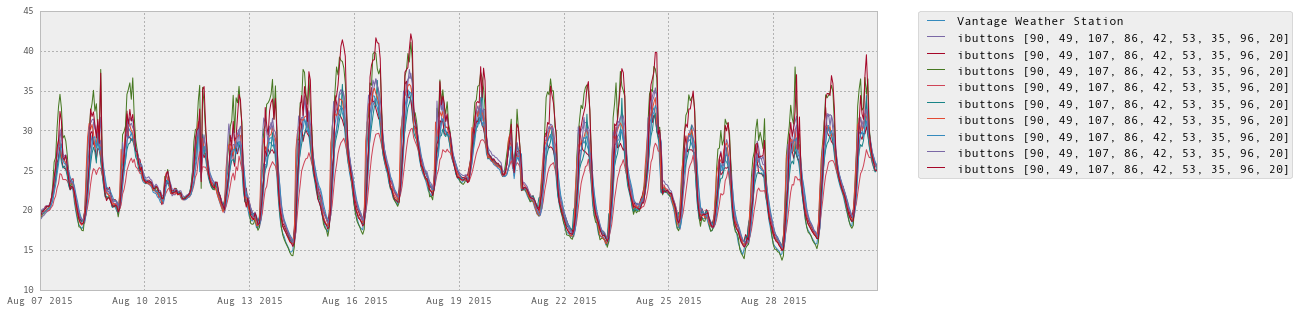

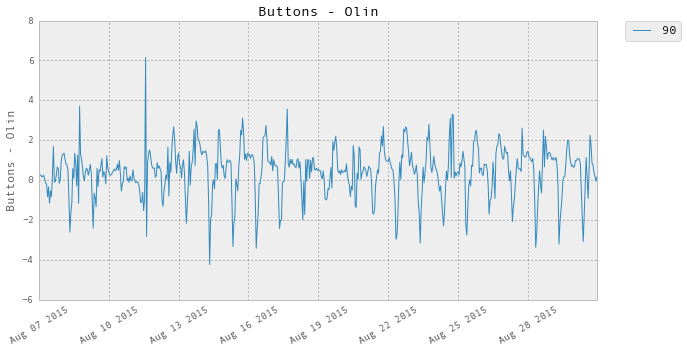

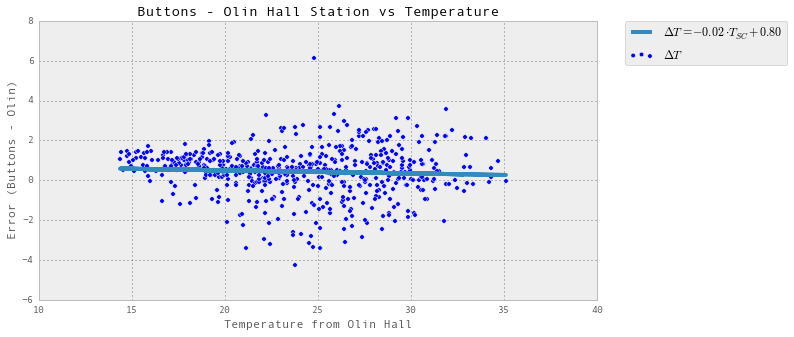

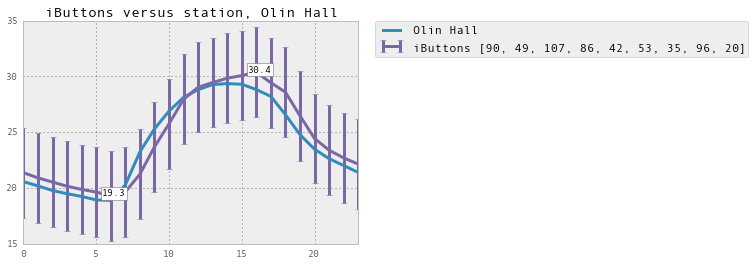

In [70]:
# Buttons vs. Olin Hall
fig = plt.figure(figsize=[15,5])
#buttons = [90, 49, 107, 86, 51, 42, 53, 35, 100, 96, 20] 
#buttons in full shade : 35 is on roof on a tree facing north 
buttons = [90, 49, 107, 86, 42, 53, 35, 96, 20] # Olin Hall

plt.plot(olinhalldf['2015-08-07':'2015-08-30'].index, olinhalldf['2015-08-07':'2015-08-30'].outTemp, label ='Vantage Weather Station')
plt.plot(tempDF['2015-08-07':'2015-08-30'].index, tempDF['2015-08-07':'2015-08-30'][buttons], label = 'ibuttons %s'%buttons )
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

# plot timeseries of ibutton sensors -amazing grace
fig = plt.figure(figsize=[10,5])
plt.plot(tempDF['2015-08-07':'2015-08-30'].index, 
         tempDF['2015-08-07':'2015-08-30'][buttons].mean(axis=1)-olinhalldf['2015-08-07':'2015-08-30'].outTemp)
#plt.plot(ruraldf['2015-07-19':'2015-09-26'].index, ruraldf['2015-07-19':'2015-09-26'].TEMP, label = 'BWI', linewidth = 3)
plt.legend(buttons, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.title('Buttons - Olin')
plt.ylabel('Buttons - Olin')
plt.xticks(rotation=30)
plt.show()

# Plot "error" vs temp 
fig = plt.figure(figsize=[10,5])
x = olinhalldf['2015-08-07':'2015-08-30'].outTemp
y = tempDF['2015-08-07':'2015-08-30'][buttons].mean(axis=1)-olinhalldf['2015-08-07':'2015-08-30'].outTemp
plt.scatter(x,y, 
            label = '$\Delta T$')

index = np.isfinite(x) & np.isfinite(y)
m,b = np.polyfit(x[index], y[index],1)
plt.plot(x, m*x+b, 
             color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
plt.title('Buttons - Olin Hall Station vs Temperature ')
plt.xlabel('Temperature from Olin Hall')
plt.ylabel('Error (Buttons - Olin)')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
plt.show()
plt.savefig('plots/errorvstempOH.eps', format = 'eps', dpi = 600,
                    bbox_extra_artists=(lgd,), bbox_inches='tight')


# diurnal cycle 
olinhalldf['2015-08-07':'2015-08-30'].outTemp.groupby(olinhalldf['2015-08-07':'2015-08-30'].index.hour).mean().plot(
    label = 'Olin Hall', 
    linewidth = 3
    )

#ibuttons
tempDF['2015-08-07':'2015-08-30'][buttons].groupby(tempDF['2015-08-07':'2015-08-30'].index.hour).mean().mean(axis=1).plot(
    yerr = tempDF['2015-08-07':'2015-08-30'][buttons].groupby(tempDF['2015-08-07':'2015-08-30'].index.hour).mean().mean(axis=1).std(), 
    label = 'iButtons %s'%buttons, 
    linewidth = 3,
    )
maximum = tempDF['2015-08-07':'2015-08-30'][buttons].groupby(tempDF['2015-08-07':'2015-08-30'].index.hour).mean().mean(axis=1).max()
plt.text(15.5, maximum,
                 '%2.1f'%maximum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

minimum = tempDF['2015-08-07':'2015-08-30'][buttons].groupby(tempDF['2015-08-07':'2015-08-30'].index.hour).mean().mean(axis=1).min()
plt.text(5.5, minimum,
                 '%2.1f'%minimum,
                 bbox=dict(facecolor='white', edgecolor = '#636363')
                 )

plt.title('iButtons versus station, Olin Hall')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


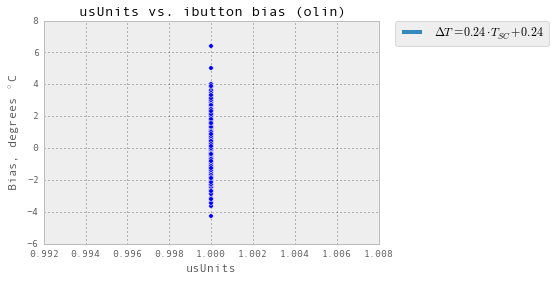

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


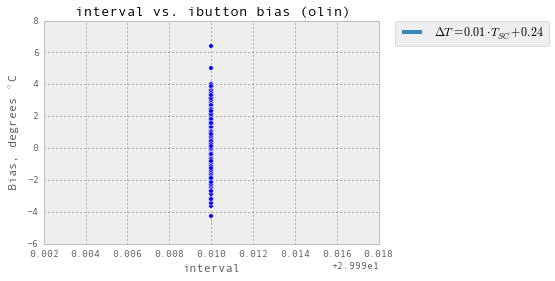

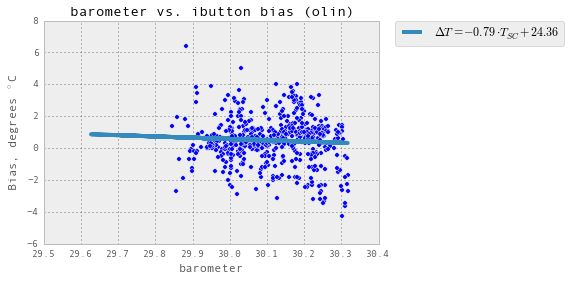

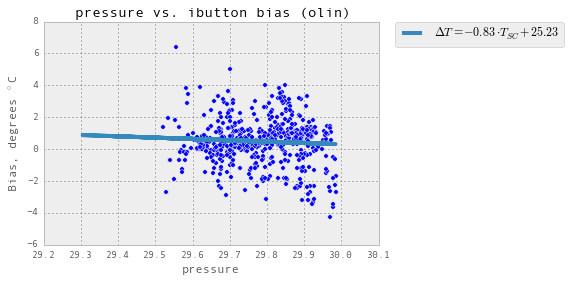

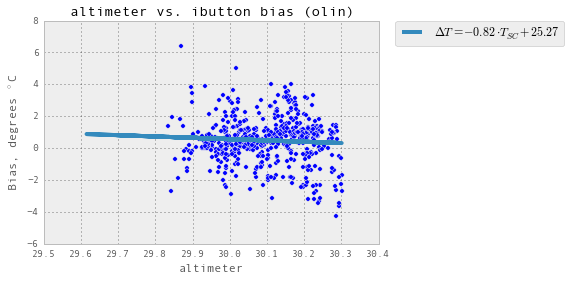

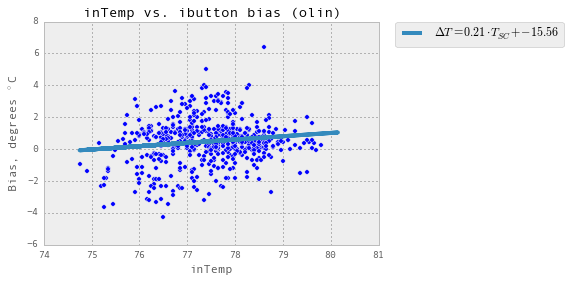

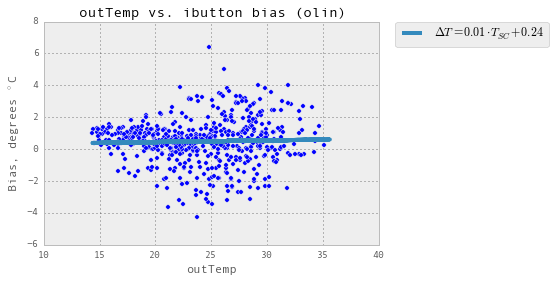

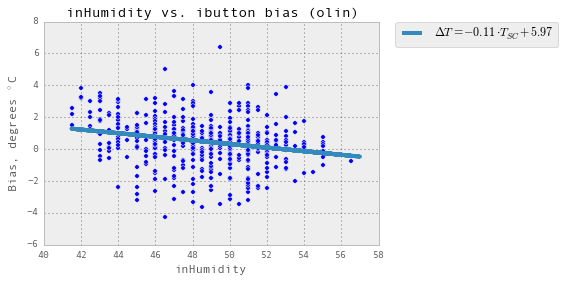

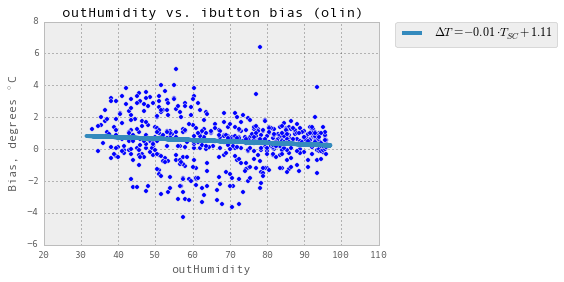

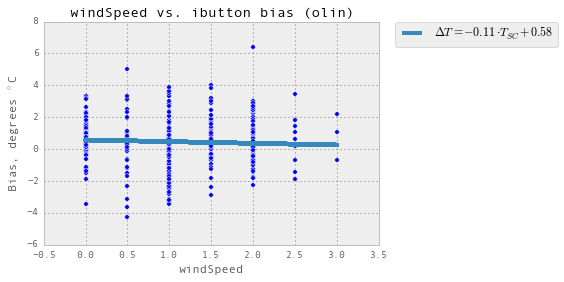

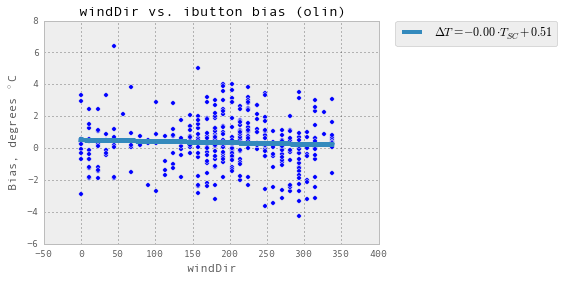

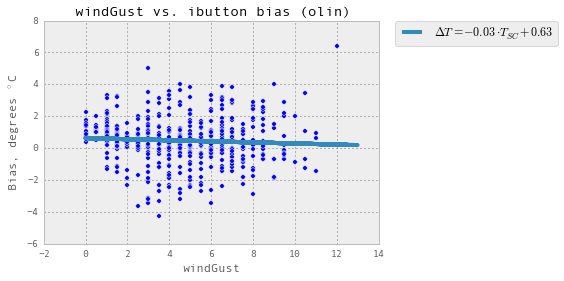

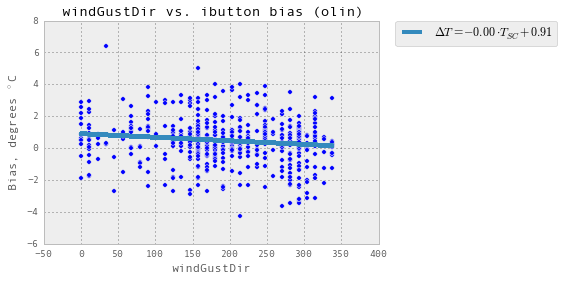

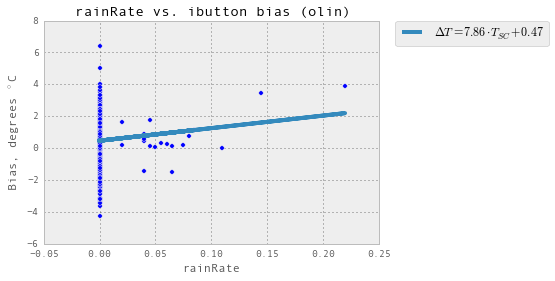

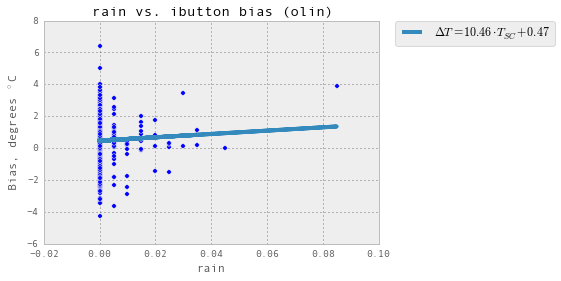

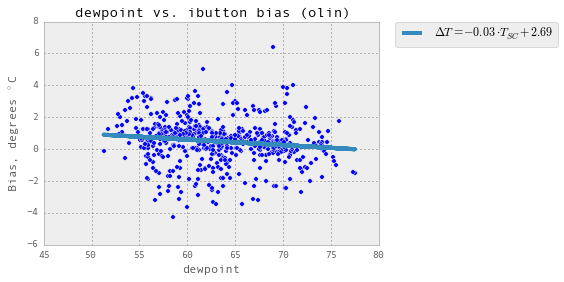

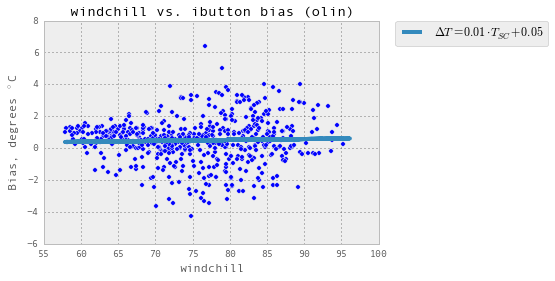

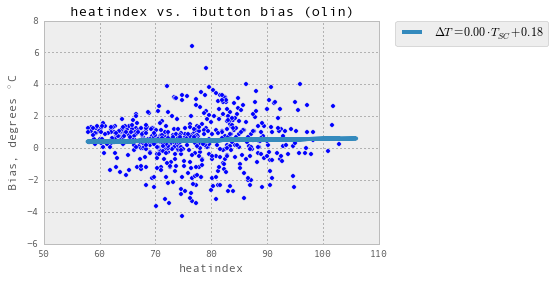

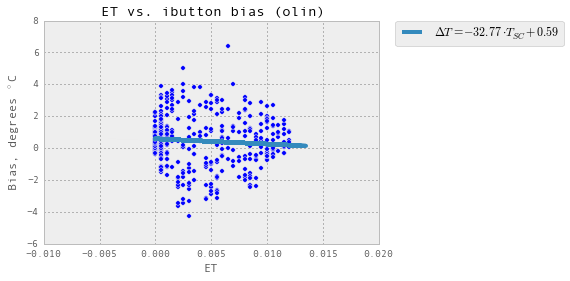

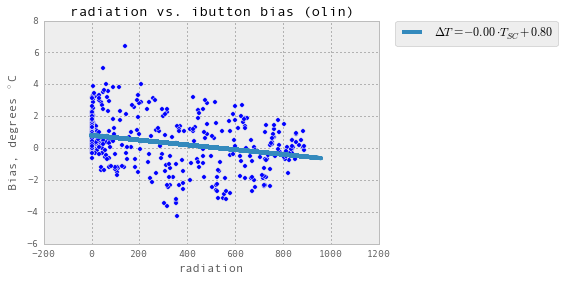

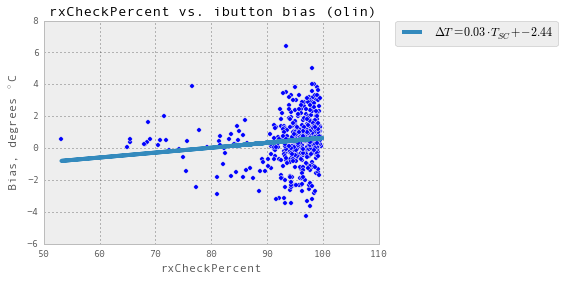

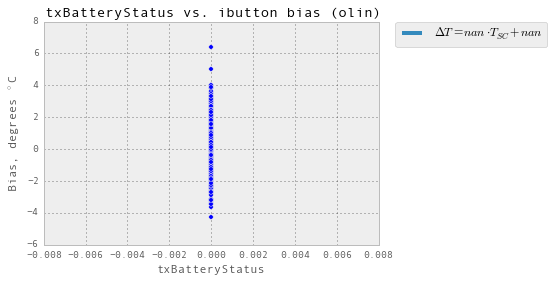

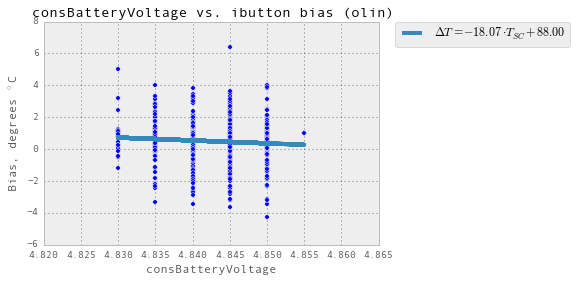

In [60]:
# olin hall bias versus weather station variables 
start = '2015-07-01'
end = '2015-08-30'
buttons = [90, 49, 107, 86, 42, 53, 35, 96, 20] # Olin Hall parking lot: 96, 20, 42,  roof: 53, 86, 35 & 90 (tree over roof)
buttons = [90, 107, 86, 53, 35, 20] # Olin Hall


for variable in olinhalldf: 
    try: 
        x = olinhalldf[variable][start:end]
        y = tempDF[start:end][buttons].mean(axis=1)-olinhalldf['2015-08-07':'2015-08-30'].outTemp
        index = ~np.isnan(x) & ~np.isnan(y)
        plt.scatter(x, y)
        m,b = np.polyfit(x[index],y[index],1)
        plt.plot(x, m*x+b,color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
        plt.ylabel('Bias, degrees $^\circ$C')
        plt.xlabel(variable)
        plt.title('%s vs. ibutton bias (olin)'%variable)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
        plt.show()
    except ValueError: 
        print 'skipping %s'%variable

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


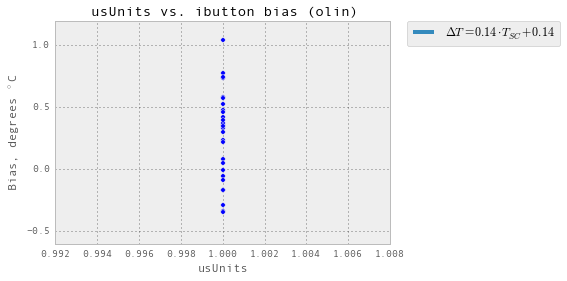

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


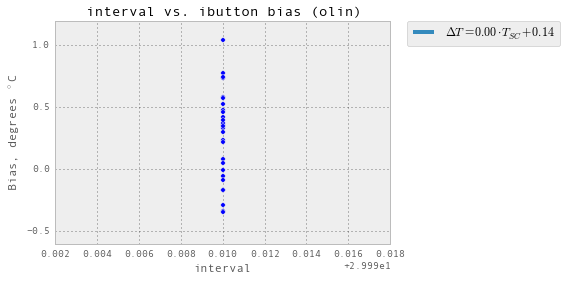

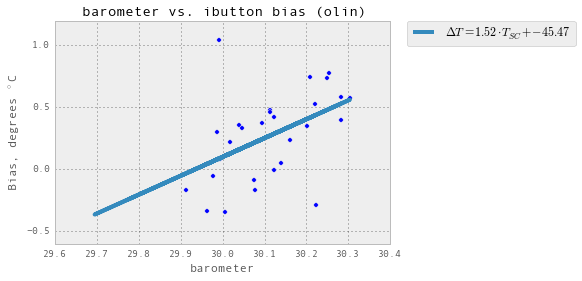

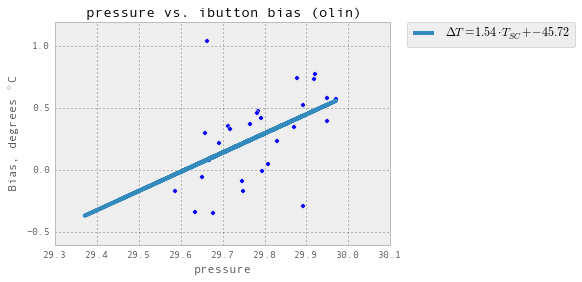

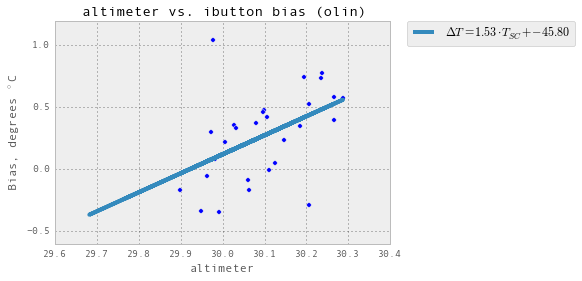

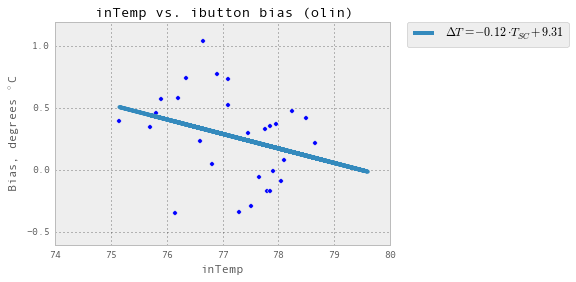

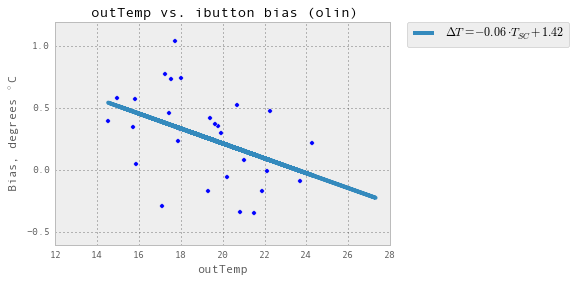

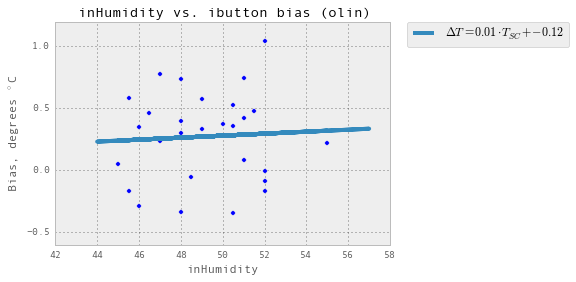

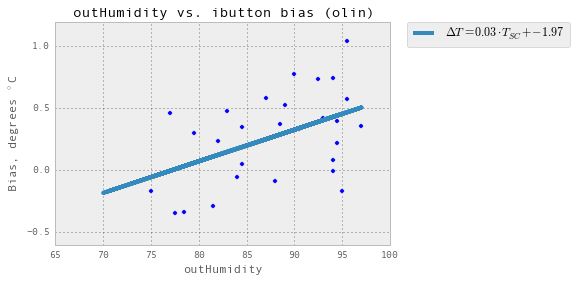

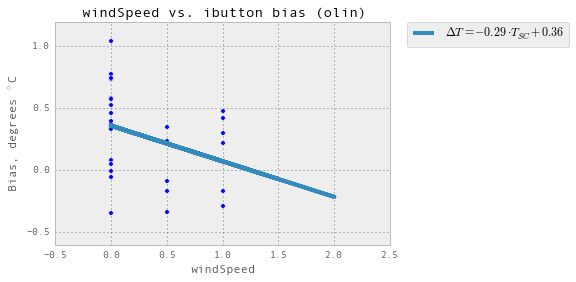

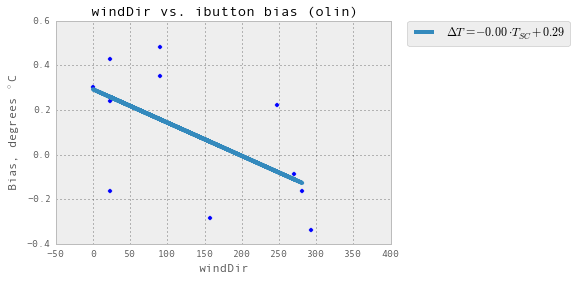

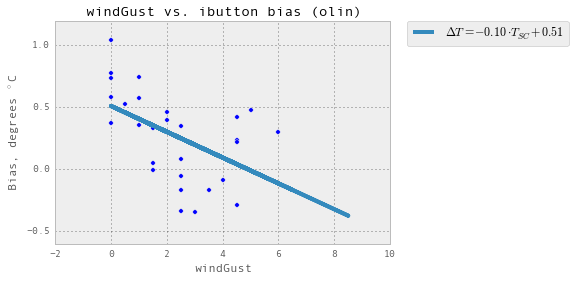

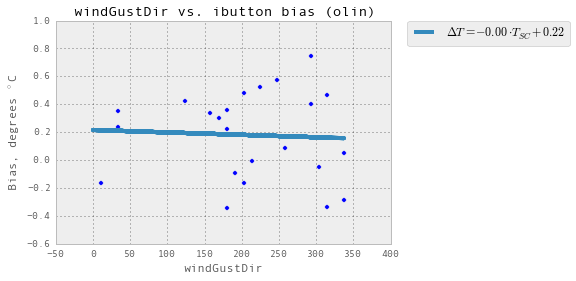

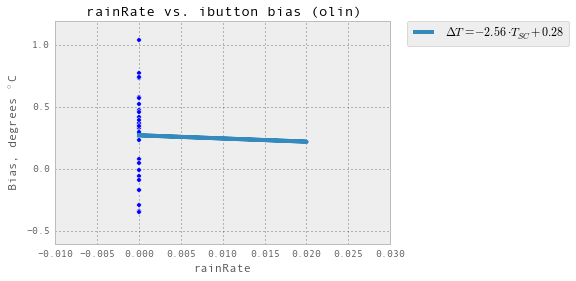

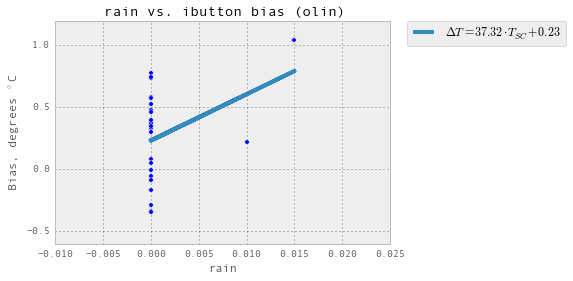

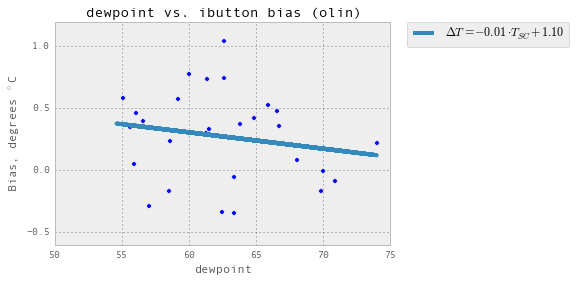

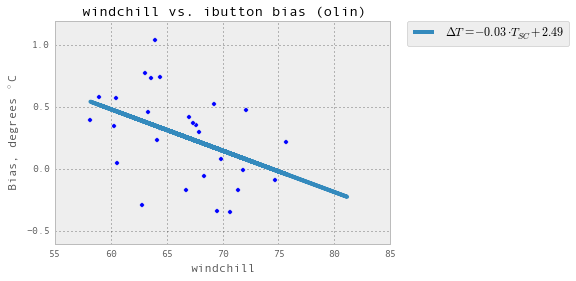

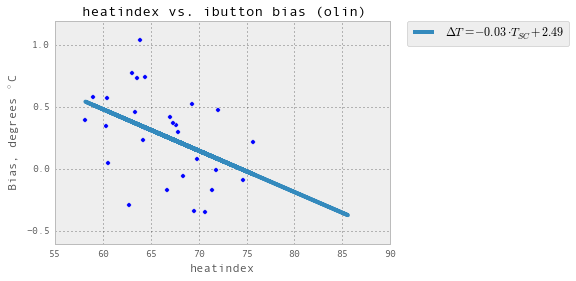

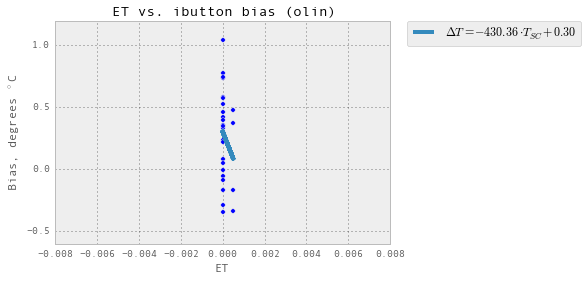

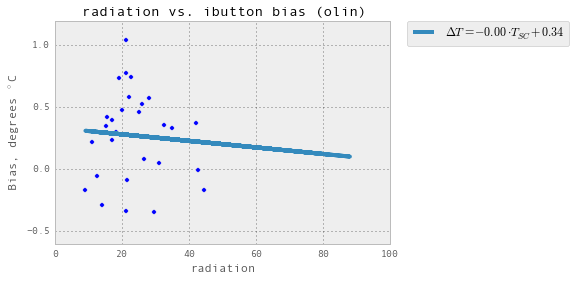

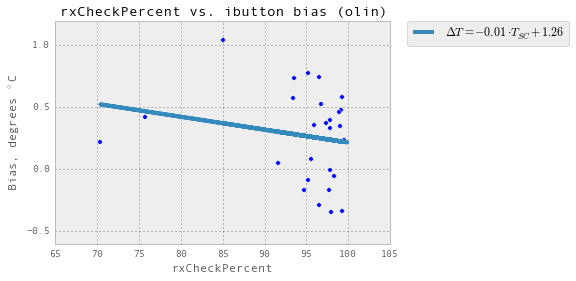

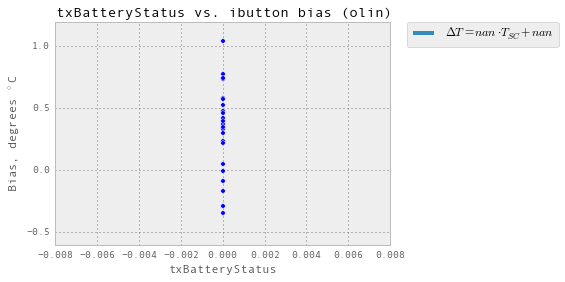

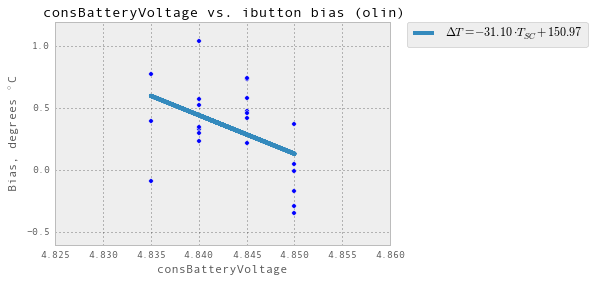

In [61]:
# olin hall bias versus weather station variables 
# Night
start = '2015-07-01'
end = '2015-08-30'
hour = 6
#buttons = [90, 49, 107, 86, 42, 53, 35, 96, 20] # Olin Hall parking lot: 96, 20, 42,  roof: 53, 86, 35 & 90 (tree over roof)
buttons = [90, 107, 86, 53, 35, 20] # Olin Hall


for variable in olinhalldf: 
    try: 
        x = olinhalldf[olinhalldf.index.hour==hour][variable][start:end]
        y = tempDF[tempDF.index.hour == hour][start:end][buttons].mean(axis=1)-olinhalldf[olinhalldf.index.hour==hour][start:end].outTemp
        index = ~np.isnan(x) & ~np.isnan(y)
        plt.scatter(x, y)
        m,b = np.polyfit(x[index],y[index],1)
        plt.plot(x, m*x+b,color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
        plt.ylabel('Bias, degrees $^\circ$C')
        plt.xlabel(variable)
        plt.title('Night %s vs. ibutton bias (olin)'%variable)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
        plt.show()
    except ValueError: 
        print 'skipping %s'%variable

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


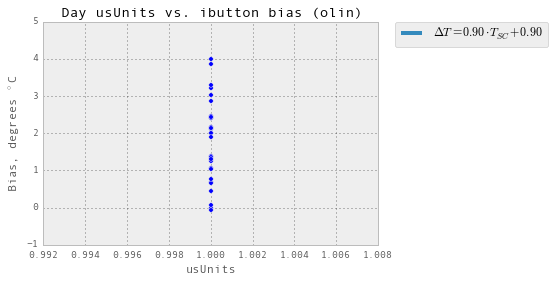

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


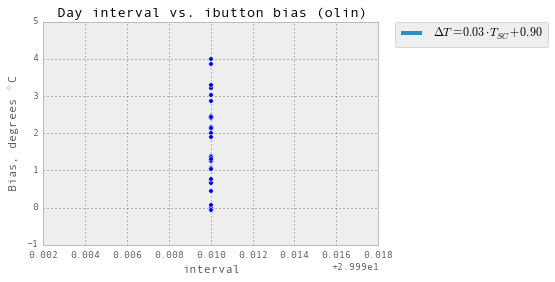

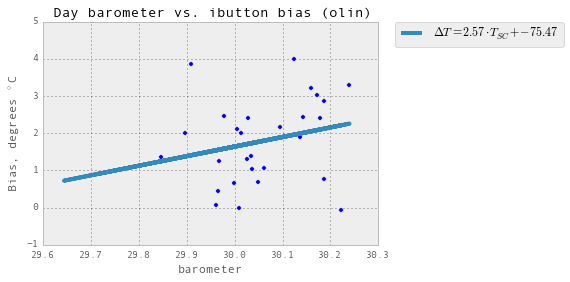

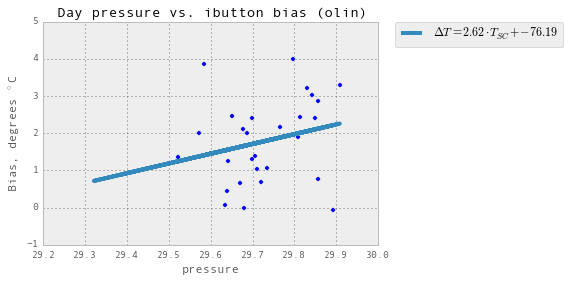

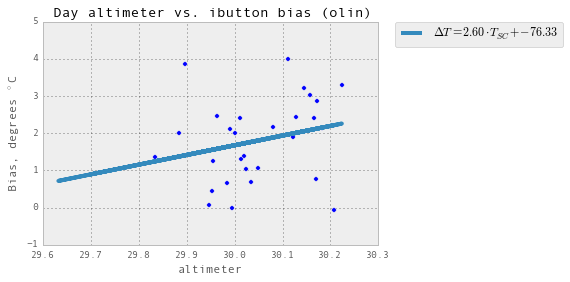

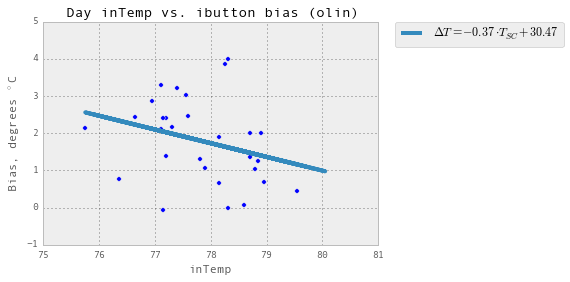

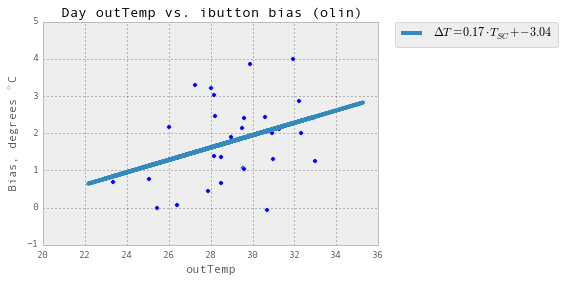

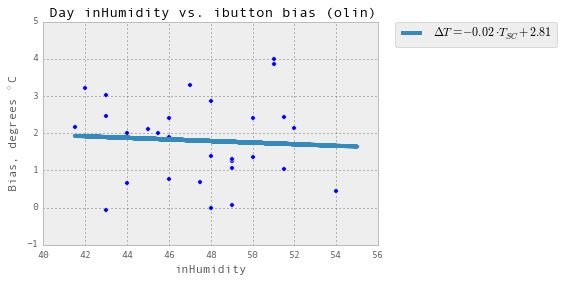

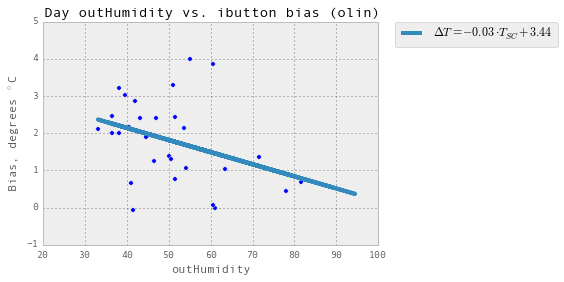

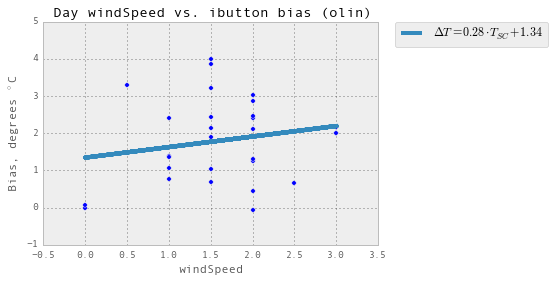

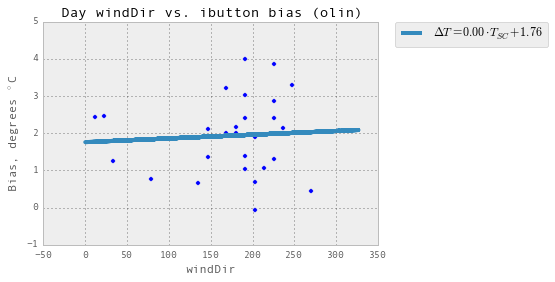

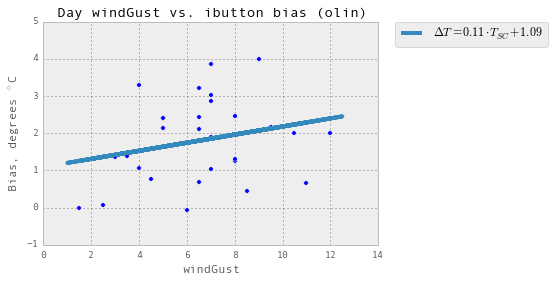

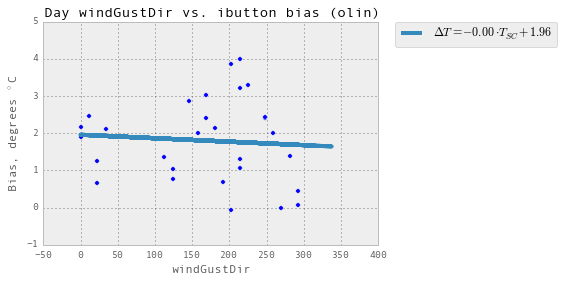

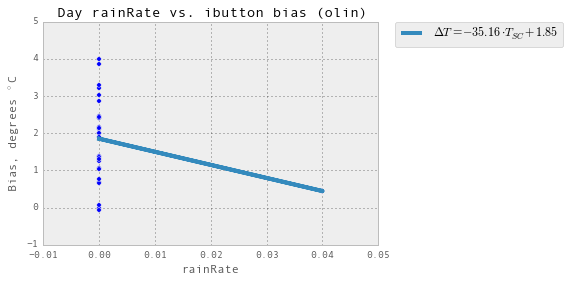

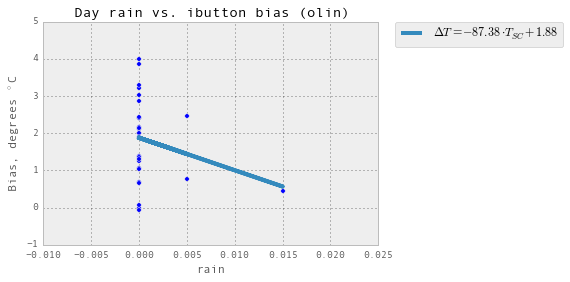

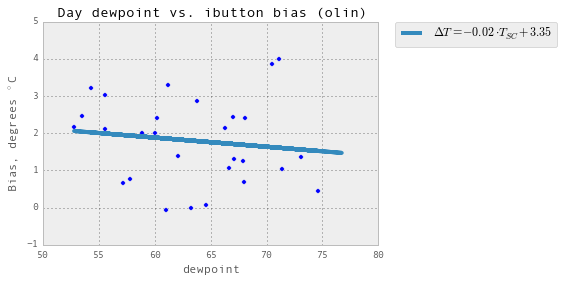

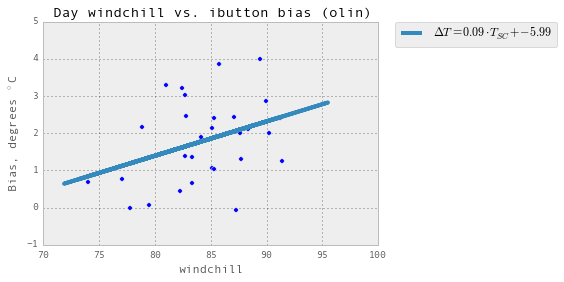

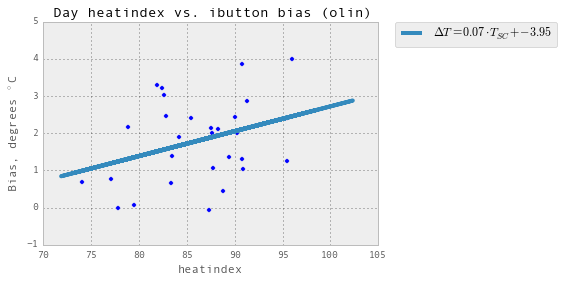

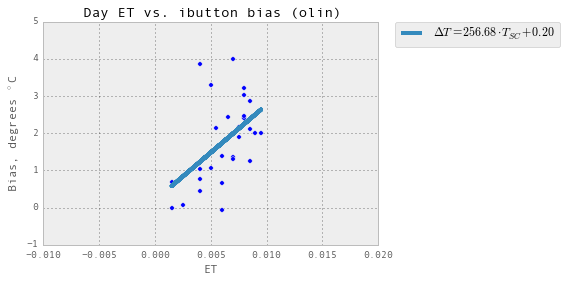

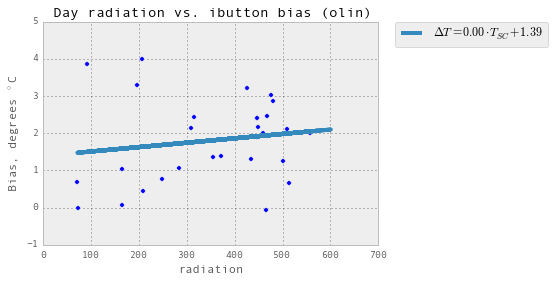

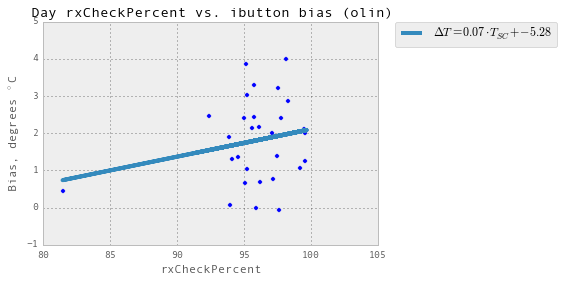

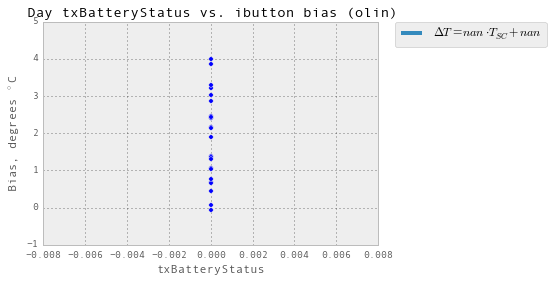

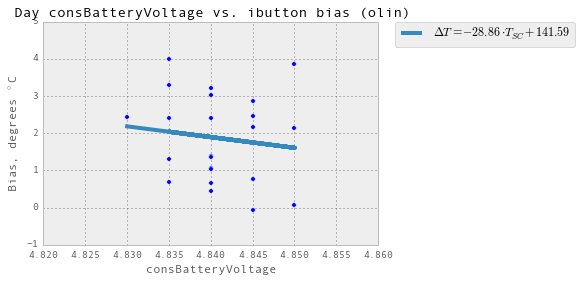

In [62]:
# olin hall bias versus weather station variables 
# Night
start = '2015-07-01'
end = '2015-08-30'
hour = 16
#buttons = [90, 49, 107, 86, 42, 53, 35, 96, 20] # Olin Hall parking lot: 96, 20, 42,  roof: 53, 86, 35 & 90 (tree over roof)
buttons = [90, 107, 86, 53, 35, 20] # Olin Hall


for variable in olinhalldf: 
    try: 
        x = olinhalldf[olinhalldf.index.hour==hour][variable][start:end]
        y = tempDF[tempDF.index.hour == hour][start:end][buttons].mean(axis=1)-olinhalldf[olinhalldf.index.hour==hour][start:end].outTemp
        index = ~np.isnan(x) & ~np.isnan(y)
        plt.scatter(x, y)
        m,b = np.polyfit(x[index],y[index],1)
        plt.plot(x, m*x+b,color = pd.tools.plotting._get_standard_colors(3)[0],
             lw =4,
             label = '$\Delta T=%.2f \cdot T_{SC}+%.2f$'%(m,b),
             )
        plt.ylabel('Bias, degrees $^\circ$C')
        plt.xlabel(variable)
        plt.title('Day %s vs. ibutton bias (olin)'%variable)
        lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)
        plt.show()
    except ValueError: 
        print 'skipping %s'%variable

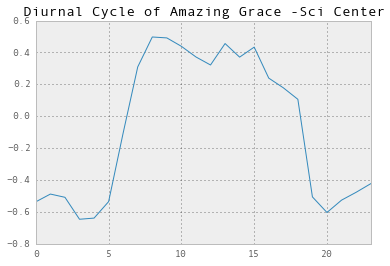

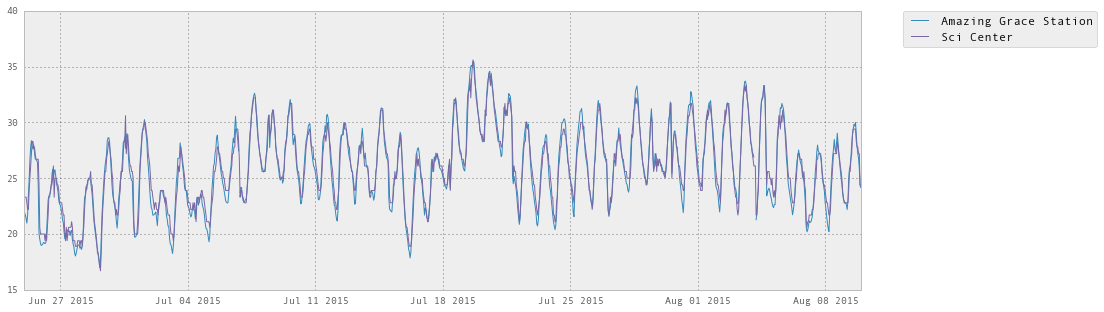

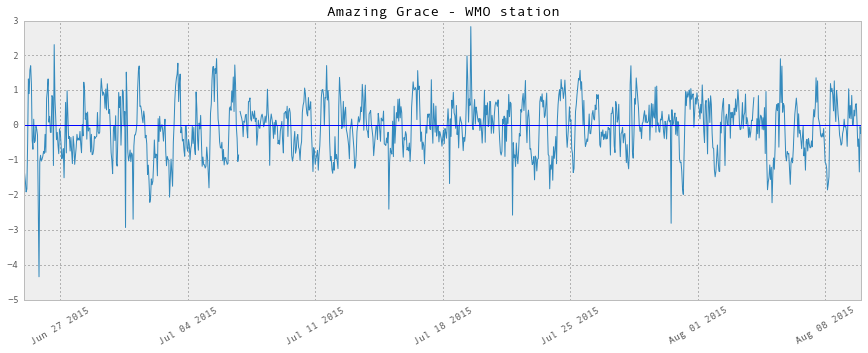

In [74]:
x = amazinggracedf['2015-06-25':'2015-08-09'].index
diff = amazinggracedf['2015-06-25':'2015-08-09'].outTemp-urbandf['2015-06-25':'2015-08-09'].TEMP
plt.title('Diurnal Cycle of Amazing Grace -Sci Center')
diff.groupby(diff.index.hour).mean().plot()

plt.figure(figsize=[15,5])
plt.plot(x, amazinggracedf['2015-06-25':'2015-08-09'].outTemp, label = 'Amazing Grace Station')
plt.plot(x, urbandf['2015-06-25':'2015-08-09'].TEMP, label = 'Sci Center')
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol = 1)

plt.figure(figsize=[15,5])
plt.plot(x, 
         amazinggracedf['2015-06-25':'2015-08-09'].outTemp-urbandf['2015-06-25':'2015-08-09'].TEMP)
plt.xticks(rotation=30)
plt.axhline(0)
plt.title('Amazing Grace - WMO station')

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


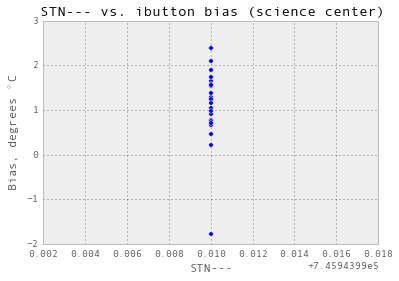

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


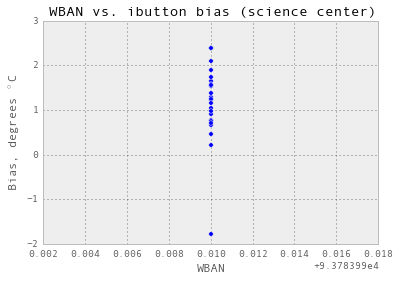

skipping YEAR
skipping MO
skipping DA


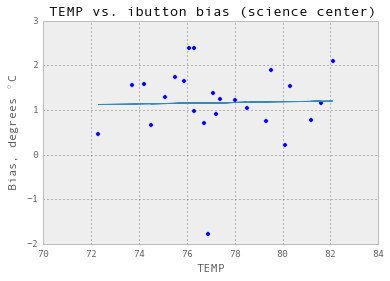

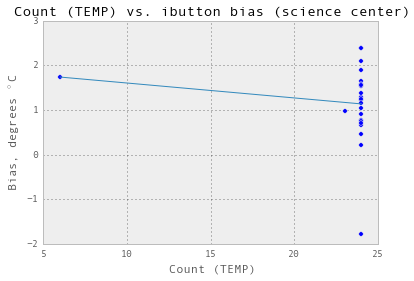

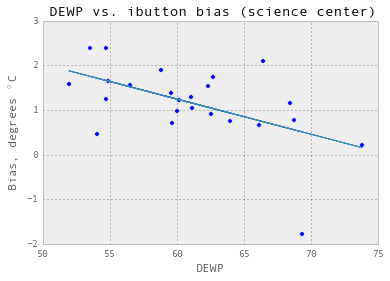

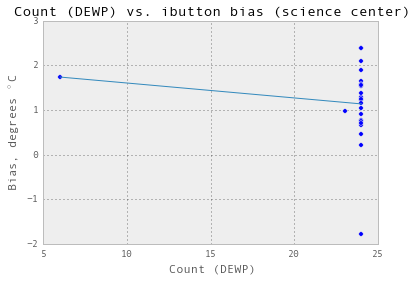

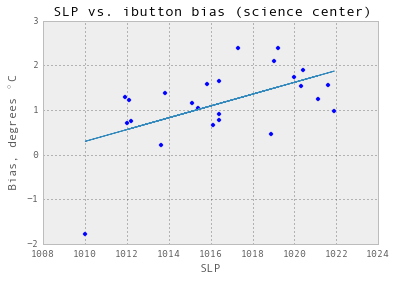

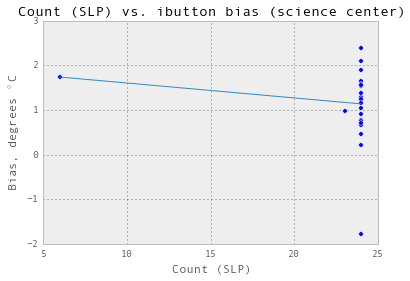

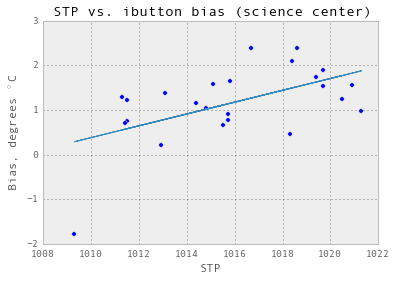

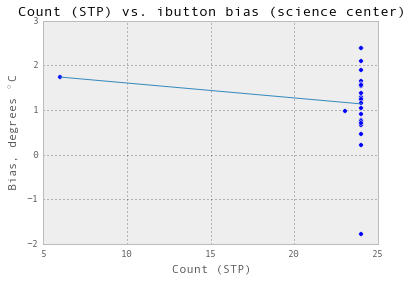

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


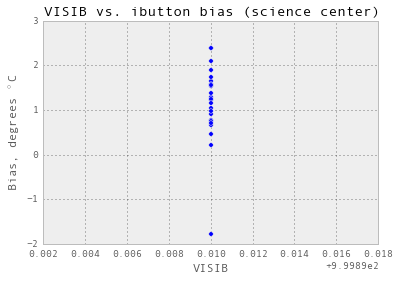

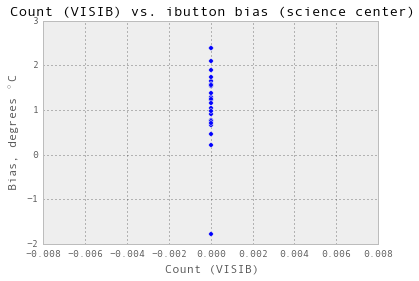

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


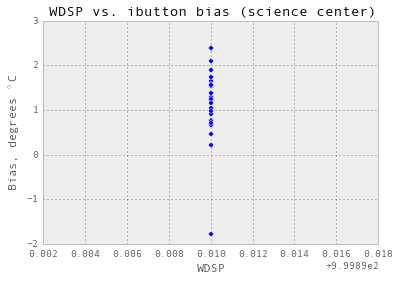

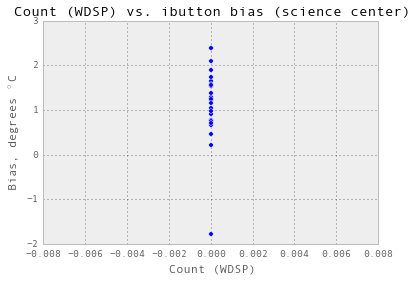

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


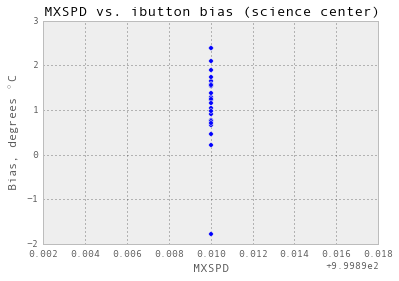

/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


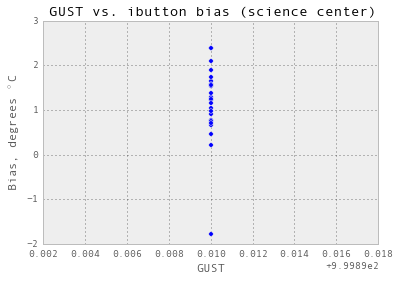

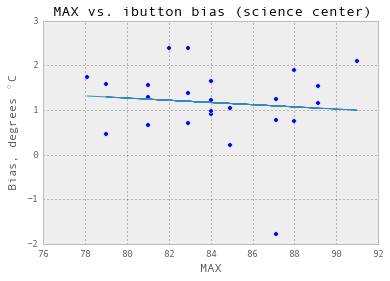

skipping Flag (MAX)


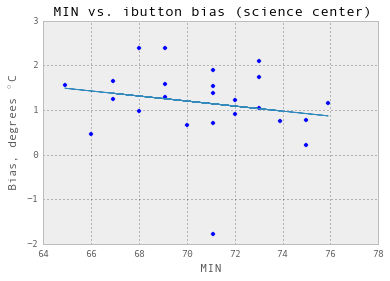

skipping Flag (MIN)


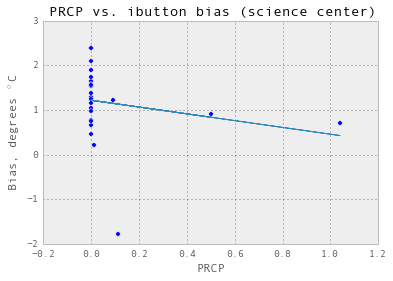

skipping Flag (PRCP)


/Users/ascott47/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


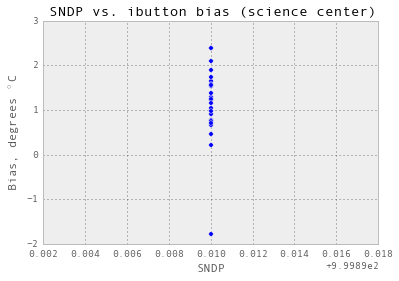

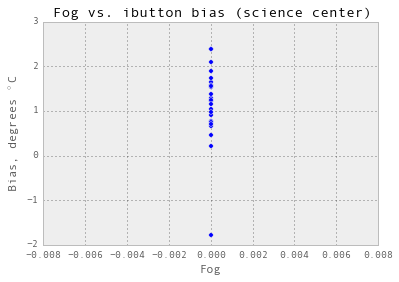

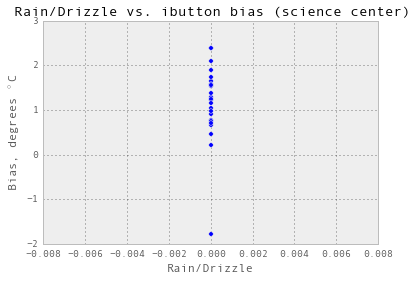

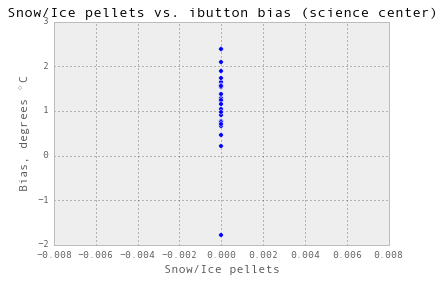

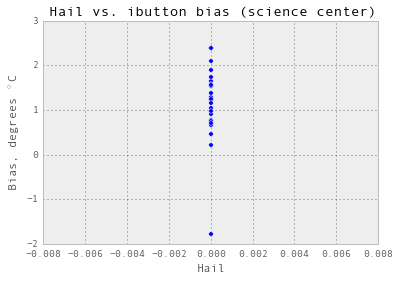

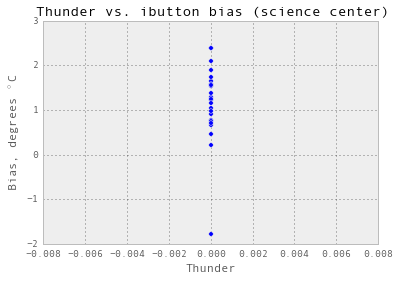

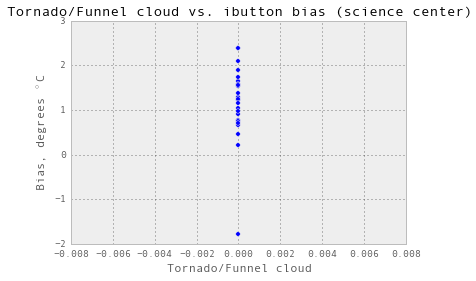

In [39]:
#Ibutton bias at science center at 
file = './data/observations/urban/2015.csv'
date_spec = {'Date': [2, 3, 4]}
dailyobs = pd.read_csv(file, sep = ',', parse_dates = date_spec, keep_date_col=True, index_col='Date')
start = '2015-08-07'
end = '2015-8-30'
hour = 16
bias = tempDF['2015-07-19':'2015-09-26'][108]-urbandf['2015-07-19':'2015-09-26'].TEMP
for variable in dailyobs: 
    try: 
        x = dailyobs[variable][start:end]
        y = bias[bias.index.hour==hour][start:end]
        plt.scatter(x, y)
        m,b = np.polyfit(x,y,1)
        plt.plot(x, m*x+b)
        plt.ylabel('Bias, degrees $^\circ$C')
        plt.xlabel(variable)
        plt.title('%s vs. ibutton bias (science center)'%variable)
        plt.show()
    except ValueError: 
        print 'skipping %s'%variable

In [ ]:
# Bias: a bot plot of Olin hall sensors
# For T_min 
fig = plt.figure()
startdate = '2015-08-3' 
enddate = '2015-10-01'
hour = 6
buttons = [90, 107, 86, 53, 35, 20]
(tempDF[tempDF.index.hour == hour][startdate:enddate][buttons] - olinhalldf[olinhalldf.index.hour ==hour][startdate:enddate].outTemp).boxplot()
plt.title('6 am Temperature at Olin Hall')
plt.xlabel('iButton number')
plt.ylabel('Temperature difference with Station')

# For T_max 
fig = plt.figure()
startdate = '2015-08-3' 
enddate = '2015-10-01'
hour = 16
buttons = [90, 107, 86, 53, 35, 20]
(tempDF[tempDF.index.hour == hour][startdate:enddate][buttons] - olinhalldf[olinhalldf.index.hour ==hour][startdate:enddate].outTemp).boxplot()
plt.title('4pm Temperature at Olin Hall')
plt.xlabel('iButton number')
plt.ylabel('Temperature difference with Station')

# For t_mean
fig = plt.figure()
startdate = '2015-08-3' 
enddate = '2015-10-01'
hour = 16
buttons = [90, 107, 86, 53, 35, 20]
(tempDF[startdate:enddate][buttons] - olinhalldf[startdate:enddate].outTemp).boxplot()
plt.title('Temperature at Olin Hall')
plt.xlabel('iButton number')
plt.ylabel('Temperature difference with Station')